In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm

import os
import copy
import time
import gc
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pathlib  # для директорії з даними
import tensorflow as tf  # для створення датасету через директорію

import keras
from keras.layers import Flatten
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential, layers

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
from keras.applications import ResNet101V2

Підключення до диску, на який попередньо було завантажено датасет.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Розпакуємо з архіву дані.

In [ ]:
import tarfile

# Шлях до архіву
archive_path = '/content/drive/MyDrive/data/101_ObjectCategories.tar.gz'

# Папка, куди розпакувати архів
extract_dir = '/content/drive/MyDrive/data'

# Розпаковка архіву
with tarfile.open(archive_path, 'r:gz') as tar:
    tar.extractall(path=extract_dir)

print("Архів розпаковано успішно.")

Архів розпаковано успішно.


### Підготовка даних

Спочатку треба підготувати та нормалізувати зображення для більш ефективного навчання майбутніх моделей.

In [ ]:
# для центрування та нормалізації кольорів зображень, середнє значення та стандартне відхилення
mean, stdev = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

Створимо функції з послідовностей перетворень зображень датасету, які потім застосуємо до даних: тренувальних та валідаційних.

In [ ]:
def train_transform(image, label):
    image = tf.image.resize(image, (224, 224))  # для ResNet треба зображення 224x224 пікселі
    image = tf.image.random_flip_left_right(image)  # випадкове перевертання по горизонталі
    image = tf.image.random_flip_up_down(image)  # аналогічно по вертикалі
    image = tf.image.random_brightness(image, 0.2)  # випадкова зміна яскравости
    image = tf.image.random_contrast(image, 0.8, 1.2)  # та контрасту
    image = tf.cast(image, tf.float32) / 255.0  # нормалізація до діапазону [0, 1]
    return image, label

def val_transform(image, label):
    image = tf.image.resize(image, (224, 224))  # 224x224 для ResNet
    image = tf.cast(image, tf.float32) / 255.0  # нормалізація до діапазону [0, 1]
    return image, label


Ініціюємо функцію, яка "заморозить" всі параметри (шари) моделі. Відповідно, вони набудуть значення False і не будуть оновлюватись під час тренування.

In [ ]:
def freeze(model):
  for layer in model.layers:
    layer.trainable = False

Функції для збереження моделі та завантаження її.

In [ ]:
def save_model(net, criterion, optimizer, PATH_PT):
    torch.save({
    'model_dict': net.state_dict(),
    'criterion_dict': criterion.state_dict(),
    'optimizer_dict': optimizer.state_dict()}, PATH_PT)

In [ ]:
def load_model(net, PATH_PT):
    checkpoint = torch.load(PATH_PT, map_location=DEVICE)  # завантажили

    net.fc = nn.Linear(net.fc.in_features, NUM_CLASSES)  # замінили останній повний з'єднувальний шар
    net = net.to(DEVICE)  # перемістили модель на пристрій

    criterion = nn.CrossEntropyLoss()  # створили новий критерій - перехресну ентропію для обчислення втрат під час навчання моделі
    optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)  # додали оптимізатор

    net.load_state_dict(checkpoint['model_dict'])
    criterion.load_state_dict(checkpoint['criterion_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_dict'])

    return net, criterion, optimizer

In [ ]:
dataset_path = '/content/drive/MyDrive/data/101_ObjectCategories'
data_dir = pathlib.Path(dataset_path)  # об'єкт із шляхом до датасету на диску

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

8677


Створимо набір тренувальних даних через директорію:

In [ ]:
ds_train = tf.keras.utils.image_dataset_from_directory(
  data_dir,  # шлях
  validation_split=0.2,  # 20% піде на валідаційну вибірку
  subset="training",
  seed=123,  # seed потрібен для генерації випадкової вибірки даних
  batch_size=32,  # розмір "партії" даних
  image_size=(256, 256))  # розмір зображень

Found 8677 files belonging to 101 classes.
Using 6942 files for training.


Аналогічно створимо набір валідаційних даних через директорію:

In [ ]:
ds_val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  batch_size=32,
  image_size=(256, 256))

Found 8677 files belonging to 101 classes.
Using 1735 files for validation.


Назви класів:

In [ ]:
class_names = ds_train.class_names
classes_count = len(class_names)
print(classes_count)

101


In [ ]:
class_names

['Faces',
 'Faces_easy',
 'Leopards',
 'Motorbikes',
 'accordion',
 'airplanes',
 'anchor',
 'ant',
 'barrel',
 'bass',
 'beaver',
 'binocular',
 'bonsai',
 'brain',
 'brontosaurus',
 'buddha',
 'butterfly',
 'camera',
 'cannon',
 'car_side',
 'ceiling_fan',
 'cellphone',
 'chair',
 'chandelier',
 'cougar_body',
 'cougar_face',
 'crab',
 'crayfish',
 'crocodile',
 'crocodile_head',
 'cup',
 'dalmatian',
 'dollar_bill',
 'dolphin',
 'dragonfly',
 'electric_guitar',
 'elephant',
 'emu',
 'euphonium',
 'ewer',
 'ferry',
 'flamingo',
 'flamingo_head',
 'garfield',
 'gerenuk',
 'gramophone',
 'grand_piano',
 'hawksbill',
 'headphone',
 'hedgehog',
 'helicopter',
 'ibis',
 'inline_skate',
 'joshua_tree',
 'kangaroo',
 'ketch',
 'lamp',
 'laptop',
 'llama',
 'lobster',
 'lotus',
 'mandolin',
 'mayfly',
 'menorah',
 'metronome',
 'minaret',
 'nautilus',
 'octopus',
 'okapi',
 'pagoda',
 'panda',
 'pigeon',
 'pizza',
 'platypus',
 'pyramid',
 'revolver',
 'rhino',
 'rooster',
 'saxophone',
 'sc

Приклад створення і застосування до зображень шару для нормалізації пікселів з діапазону 0-255 до 0-1:

In [ ]:
norm_layer = tf.keras.layers.Rescaling(1./255)

ds_normalized = ds_train.map(lambda x, y: (norm_layer(x), y))
image_batch, labels_batch = next(iter(ds_normalized))
first_image = image_batch[0]

print("Найменше значення:", np.min(first_image), "Найбільше:", np.max(first_image))

Найменше значення: 0.008224667 Найбільше: 1.0


Використаємо дві хитрі функції для підвищення швидкості навчання.<br>

*   Метод .cache() збереже дані у пам'яті після першого читання, що дозволить уникнути повторного читання з диска при наступних епохах тренування.<br>
*   Метод .prefetch() завантажить зображення з датасету у фоновому режимі під час тренування моделі, що дозволить підвищити ефективність використання ресурсів під час тренування.<br>

*   Параметр buffer_size=AUTOTUNE дозволяє автоматично вибрати оптимальний розмір буфера для кешування та попереднього завантаження, використовуючи константу AUTOTUNE.





In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

### 1. Проста 3-шарова CNN

Створимо послідовність шарів для аугментації (augmentation) зображень: додамо три шари для випадкового перевертання по горизонталі, випадкового обертання і випадкового масштабування. Ці шари потрібні, щоб розширити тренувальний набір даних. <br>

*Примітка:* пізніше я забрала перший та третій шар, адже модель навчалася дуже повільно, а зменшення датасету, який без того сам по собі великий, було одним із варіантів, які я спробувала, аби прискорити навчання.

In [ ]:
data_augmentation = keras.Sequential(
  [
    #  tf.keras.layers.RandomFlip("horizontal",
    #                   input_shape=(height,
    #                               width,
    #                               3)),  # перевертання по горизонталі
     tf.keras.layers.RandomRotation(0.1),  # обертання
    #  tf.keras.layers.RandomZoom(0.1),  # масштабування
  ]
)

#### 1.1 Навчання

Створюємо модель (спочатку в мене було по 64 фільтри в згорткових шарах і 128 нейронів у dense-шарі, але модель при таких параметрах мала би вчитися на 20 епохах понад 6 годин, тому, можливо жертвуючи при цьому якістю моделі, я була змушена їх зменшити):

In [ ]:
model = Sequential([
  data_augmentation,  # augmentation для збільшення набору даних
  tf.keras.layers.Rescaling(1./255),  # нормалізація пікселів в діапазон 0-1
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),  # згортковий шар, 32 фільтри, розмір 3x3
  tf.keras.layers.MaxPooling2D(),  # шар пулінґу для зменшення розміру зображення
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),  # ще один згортковий шар
  tf.keras.layers.MaxPooling2D(),  # пулінґ
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),  # ще один згортковий шар
  tf.keras.layers.MaxPooling2D(),  # пулінґ
  tf.keras.layers.Dropout(0.2),  # Dropout-шар для регуляризації моделі, випадково вимикає 20% нейронів для запобігання перенавчанню
  tf.keras.layers.Flatten(),  # шар-перетворення матриці ознак у вектор
  tf.keras.layers.Dense(64, activation='relu'),  # dense-шар на 64 нейрони
  tf.keras.layers.Dense(classes_count)  #  dense-шар із кількістю нейронів = кількості класів (для задачі класифікації)
])

Компіляція моделі та збереження:

In [ ]:
model.compile(
              optimizer='adam',  # оптимізатор Adam
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # функція втрат
              metrics=['accuracy']  # точність, скільки класів показала правильно
)

callbacks = [
 keras.callbacks.ModelCheckpoint(
 filepath='/content/drive/MyDrive/callbacks',
 save_best_only=True,  # зберігатиме модель після кожної епохи, де втрати на валідаційній вибірці покращуються
 monitor="val_loss")
]

Навчаємо модель:

In [ ]:
history = model.fit(
  ds_train,
  validation_data=ds_val,
  epochs=15,
  callbacks = callbacks
)

Epoch 1/15
217/217 [==============================] - 66s 276ms/step - loss: 3.9067 - accuracy: 0.1999 - val_loss: 3.4276 - val_accuracy: 0.2720
Epoch 2/15
217/217 [==============================] - 26s 117ms/step - loss: 3.2616 - accuracy: 0.3137 - val_loss: 3.0806 - val_accuracy: 0.3447
Epoch 3/15
217/217 [==============================] - 26s 118ms/step - loss: 2.9545 - accuracy: 0.3652 - val_loss: 2.8490 - val_accuracy: 0.3781
Epoch 4/15
217/217 [==============================] - 24s 111ms/step - loss: 2.7116 - accuracy: 0.3966 - val_loss: 2.6255 - val_accuracy: 0.4167
Epoch 5/15
217/217 [==============================] - 20s 94ms/step - loss: 2.5187 - accuracy: 0.4290 - val_loss: 2.5174 - val_accuracy: 0.4340
Epoch 6/15
217/217 [==============================] - 21s 96ms/step - loss: 2.3390 - accuracy: 0.4569 - val_loss: 2.4045 - val_accuracy: 0.4450
Epoch 7/15
217/217 [==============================] - 21s 97ms/step - loss: 2.1994 - accuracy: 0.4846 - val_loss: 2.3104 - val_accur

Збережемо модель, після чого спробуємо її завантажити з диску і вивести архітектуру (через summary), точність, передбачення.

In [ ]:
model.save('/content/drive/MyDrive/models/')

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/models/')

new_model.summary()  # архітектура
loss, acc = new_model.evaluate(ds_val, verbose=2)  # точність моделі на валідаційному наборі даних
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))  # вивід у %

print(new_model.predict(ds_val).shape)  # виводить форму виходу передбачень моделі для валідаційного набору даних

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                 

#### 1.2 Звіт результатів тренування/валідації

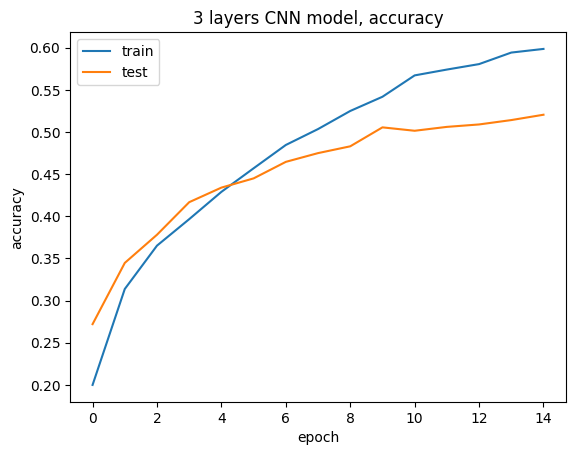

In [ ]:
# графік навчання, точність моделі
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('3 layers CNN model, accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

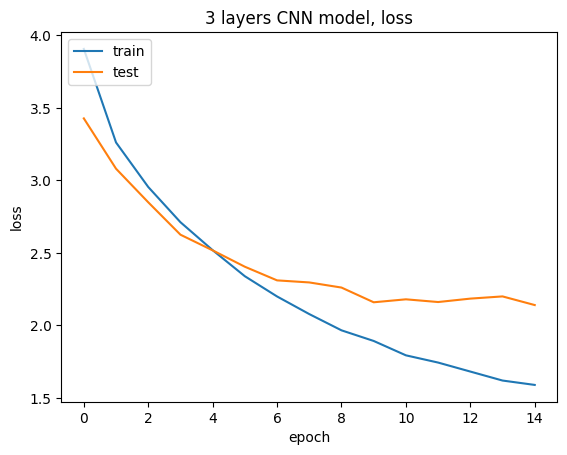

In [ ]:
# графік навчання, втрати під час навчання моделі
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('3 layers CNN model, loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Звіт про класифікацію:

In [ ]:
from sklearn.metrics import classification_report

# Передбачення міток для датасету ds_val
predictions = []
true_labels = []

for images, labels in ds_val:
    predictions.extend(new_model.predict(images))
    true_labels.extend(labels.numpy())

# Перетворення передбачень у масив NumPy
predictions = np.array(predictions)
# Перетворення передбачень в мітки (наприклад, 0 або 1 для бінарної класифікації)
predicted_labels = np.argmax(predictions, axis=1)

# Отримання звіту про класифікацію
report = classification_report(true_labels, predicted_labels)

print(report)

1/1 [==============================] - 0s 227ms/step
              precision    recall  f1-score   support

           0       0.76      0.97      0.86        79
           1       0.98      0.95      0.96        94
           2       0.90      0.93      0.91        28
           3       0.93      0.99      0.96       176
           4       0.54      0.47      0.50        15
           5       0.93      0.91      0.92       163
           6       0.00      0.00      0.00         7
           7       0.20      0.20      0.20         5
           8       0.00      0.00      0.00        11
           9       0.00      0.00      0.00        14
          10       0.50      0.06      0.11        16
          11       0.14      0.50      0.22         2
          12       0.70      0.63      0.67        30
          13       0.28      0.41      0.33        17
          14       0.16      0.75      0.26         4
          15       0.44      0.30      0.36        23
          16       0.12     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Матриця невідповідностей (confusion matrix):

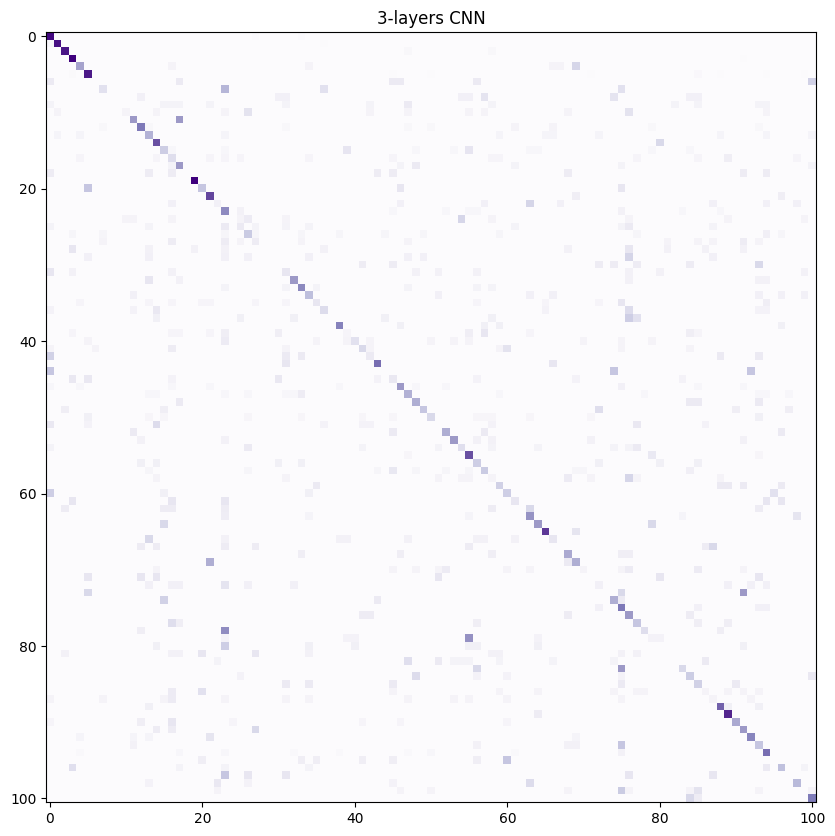

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')
fig, ax = plt.subplots(figsize=(30, 10))
ax.imshow(matrix, cmap='Purples')
ax.set_title('3-layers CNN')
plt.show()

ROC curve plot:

ROC Curves. 3-layers CNN
55/55 [==============================] - 6s 90ms/step


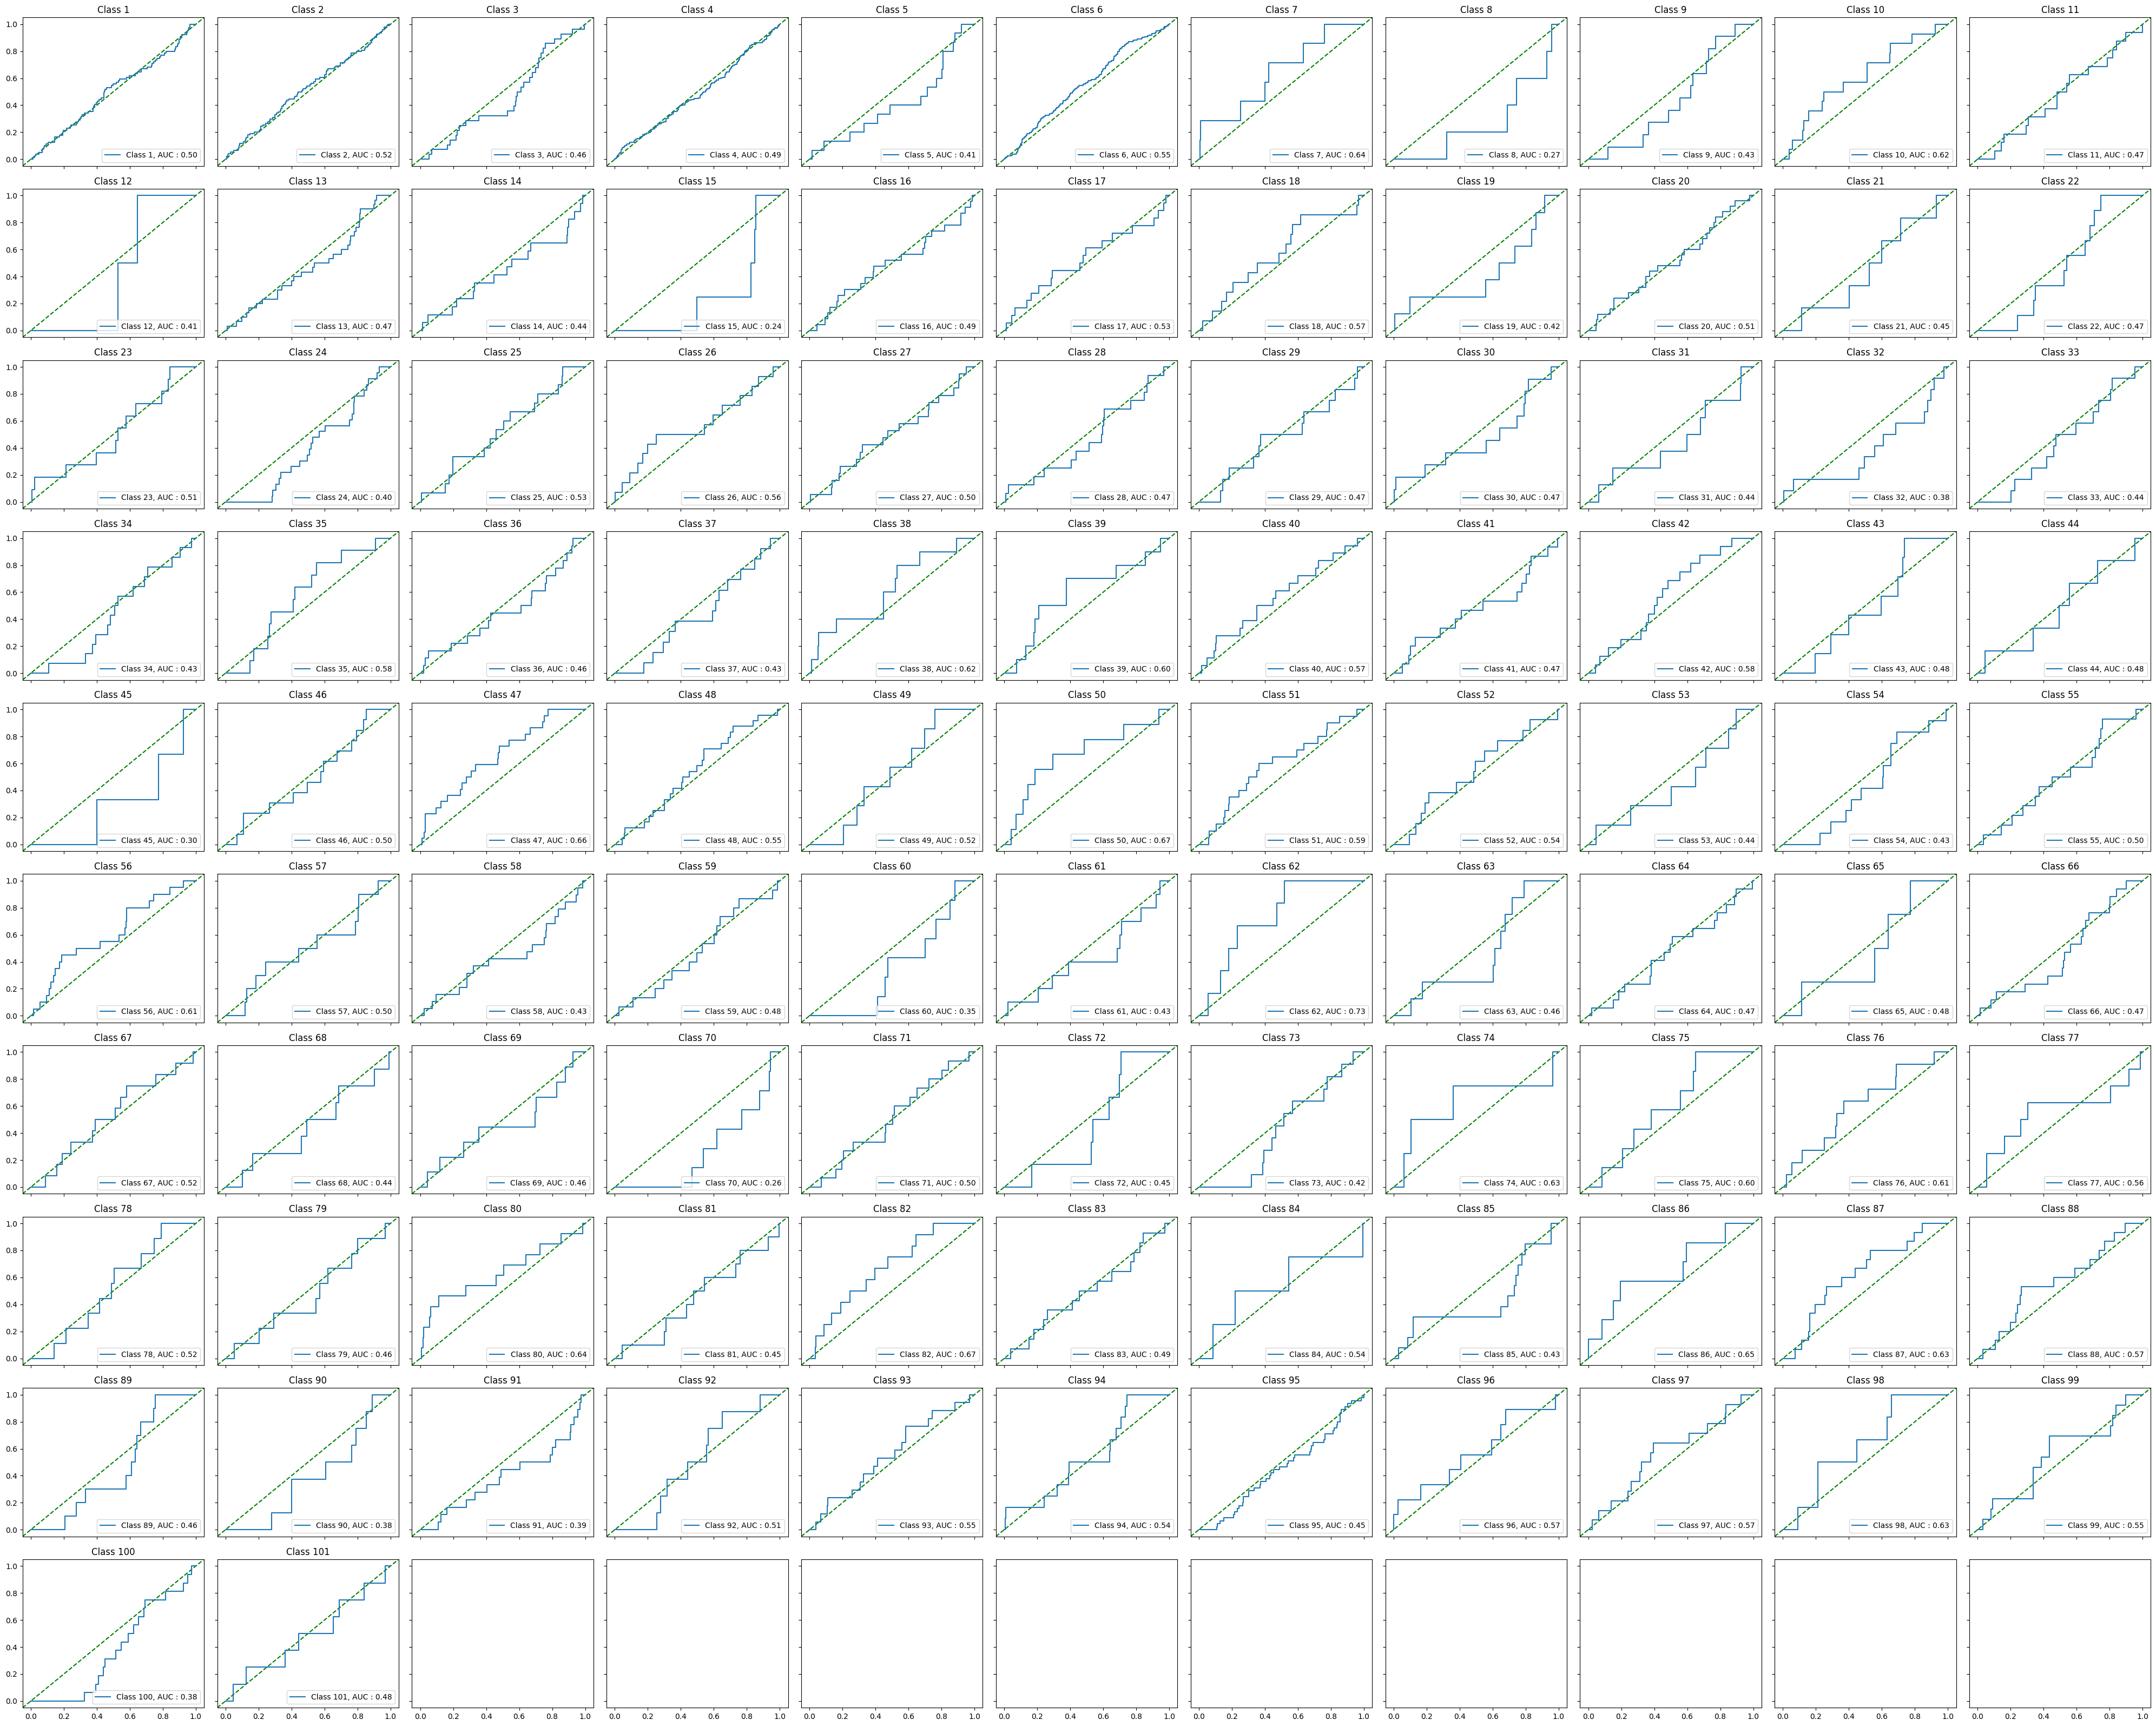

In [ ]:
import matplotlib.lines as mlines
from sklearn.metrics import roc_curve, auc

print("ROC Curves. 3-layers CNN")

# масив істинних підписів, взятих з ds_val
true_labels = []
for images, labels in ds_val:
  true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# створюємо one-hot вектори міток
true_labels_one_hot = tf.one_hot(true_labels, depth=classes_count)
model_probs = new_model.predict(ds_val)  # передбачення моделі

fig, axs = plt.subplots(10, 11, figsize=(40, 32), sharex=True, sharey=True)
for i in range(classes_count):
  ax = axs[i // 11, i % 11]
  line = mlines.Line2D([0, 1], [0, 1], ls="--", color='green')  # діагональ ROC-кривої
  transform = ax.transAxes  # визначення трансформації для координат, щоб правильно побудувати лінію
  line.set_transform(transform)  # встановлення трансформації для лінії

  # побудова ROC curve
  fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], model_probs[:, i])
  auc_score = auc(fpr, tpr)  # площа під ROC-кривою для значень FPR та TPR (false/true positive rate)

  ax.add_line(line)
  ax.plot(fpr, tpr, label=f'Class {i+1}, AUC : {auc_score:.2f}')
  ax.legend(loc='lower right')
  ax.set_title(f'Class {i+1}')

plt.tight_layout()
plt.show()

AUC-PRC plot:

PRC Curves. 3-layers CNN
55/55 [==============================] - 5s 85ms/step


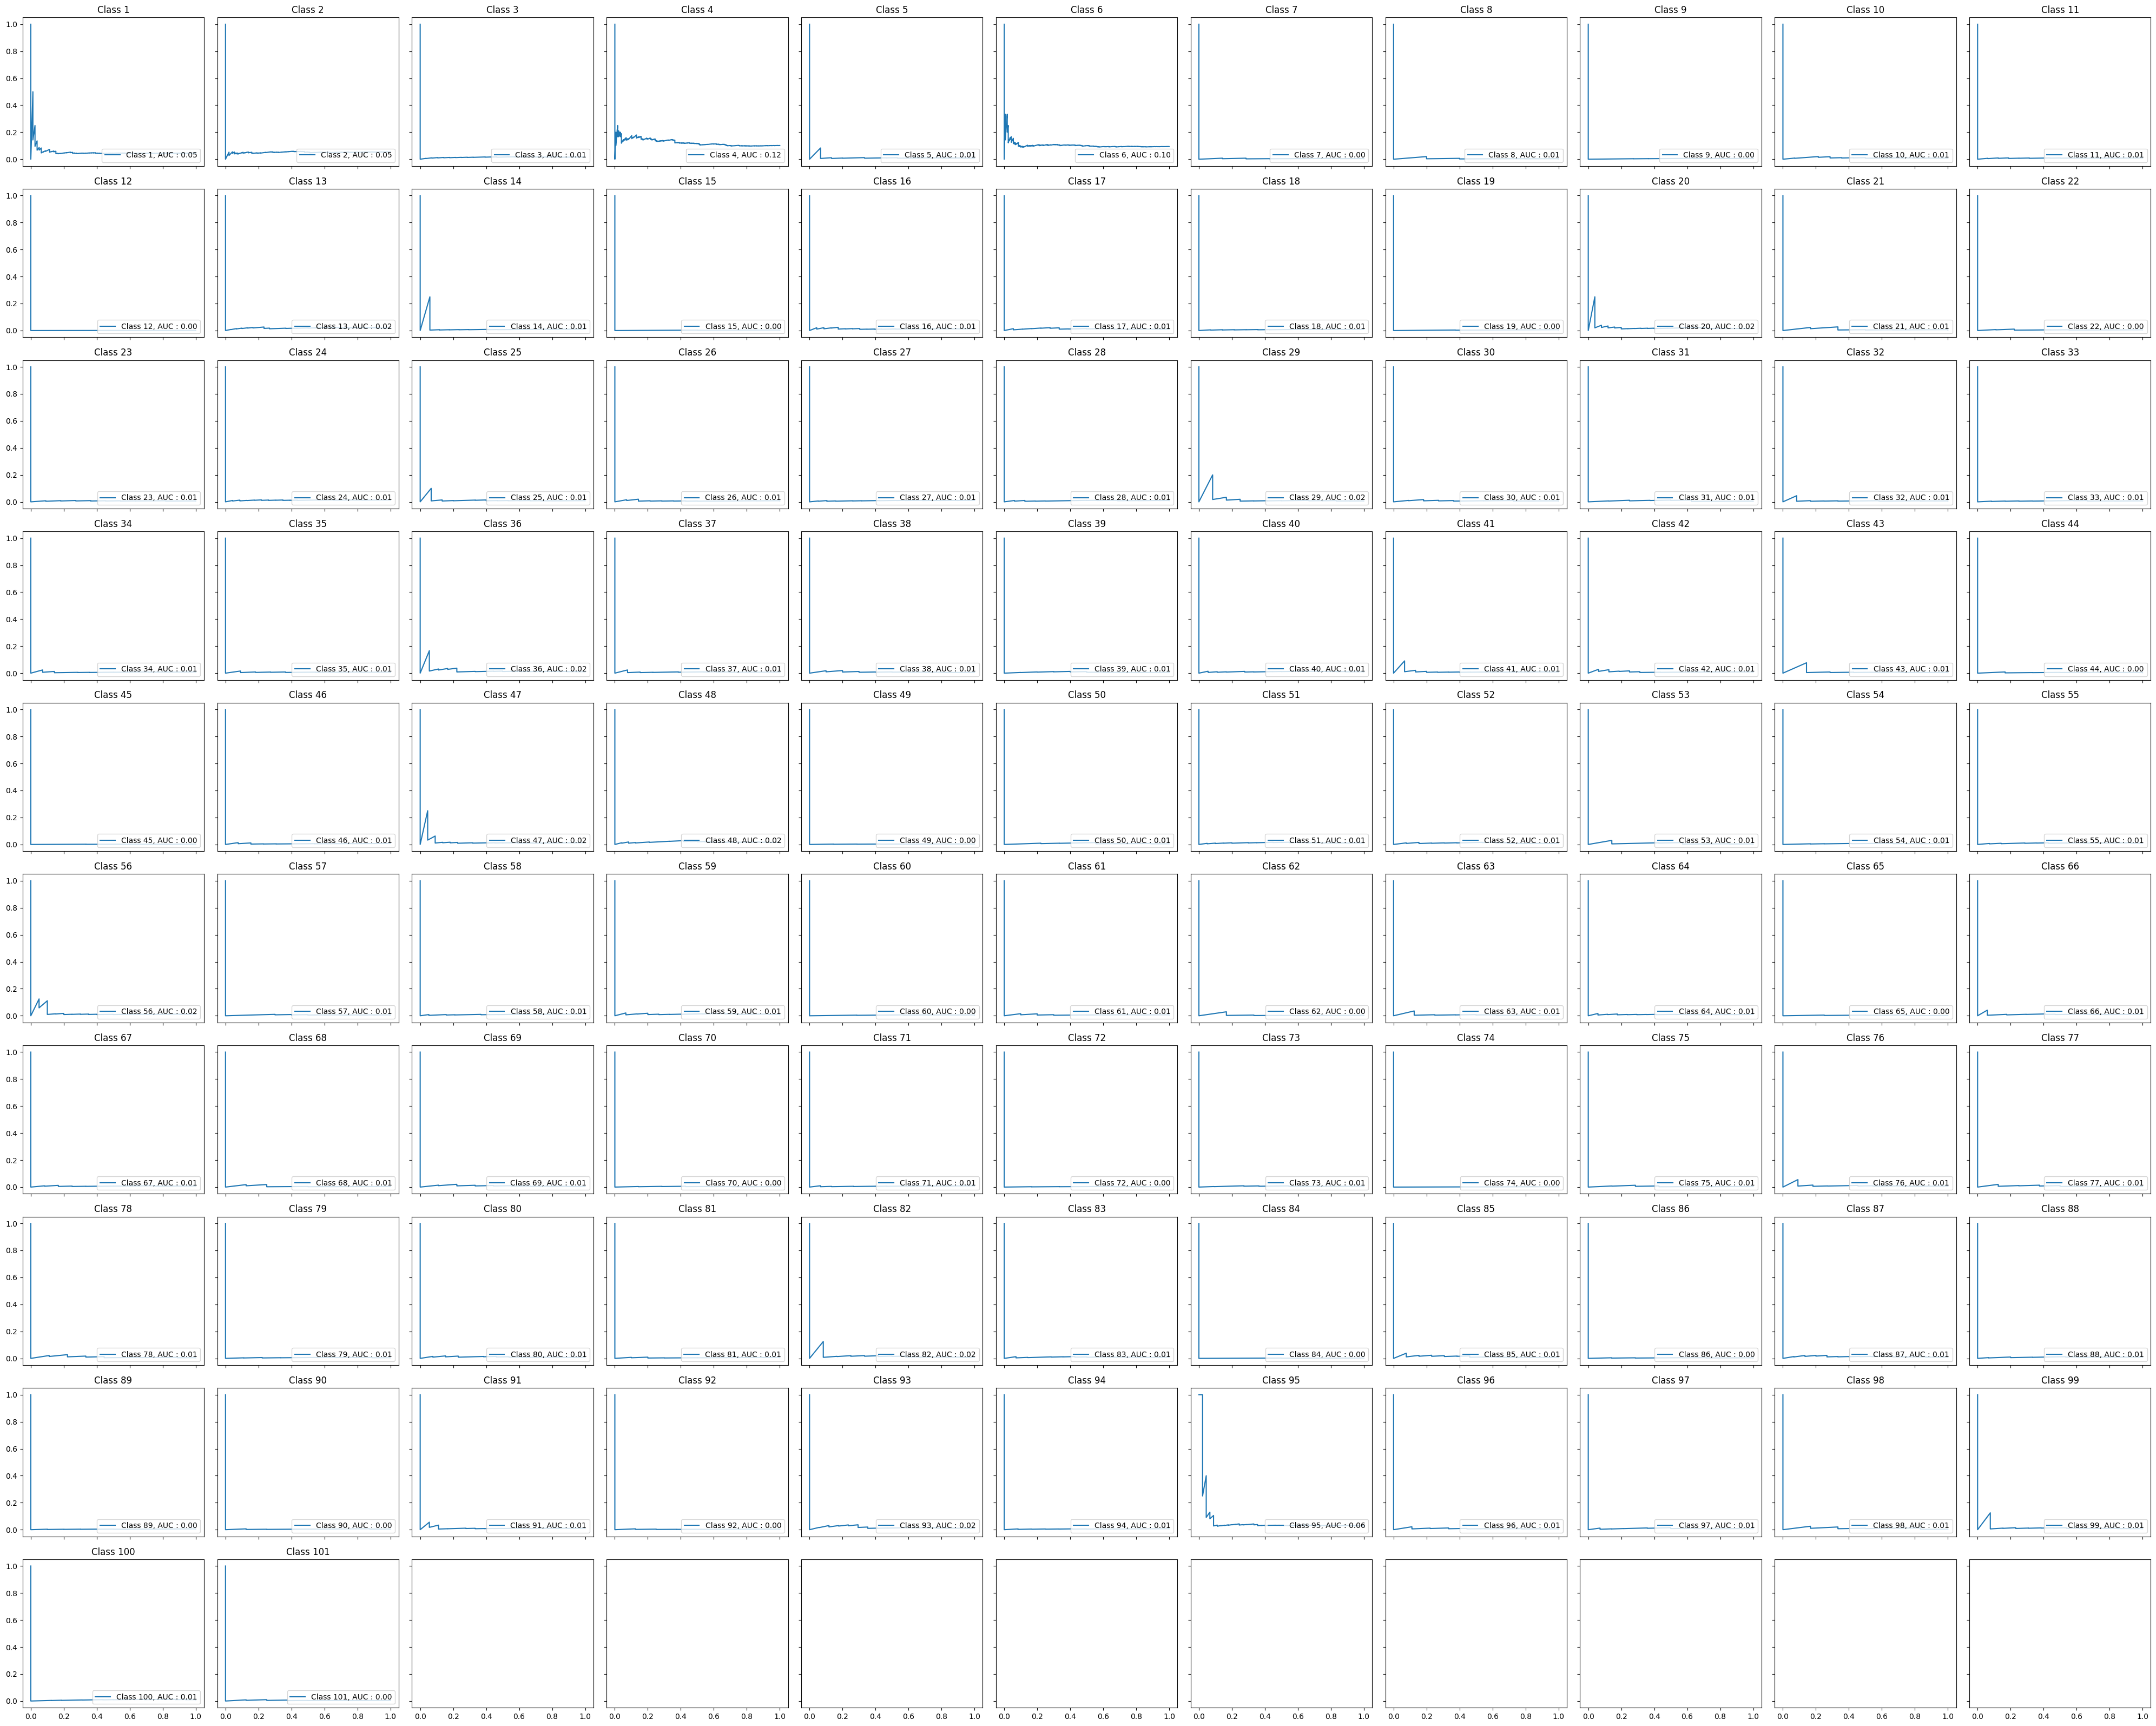

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# будуємо PRC curve
print("PRC Curves. 3-layers CNN")

# масив істинних підписів, взятих з ds_val
true_labels = []
for images, labels in ds_val:
  true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# створюємо one-hot вектори міток
true_labels_one_hot = tf.one_hot(true_labels, depth=classes_count)
model_probs = new_model.predict(ds_val)  # передбачення моделі

fig, axs = plt.subplots(10, 11, figsize=(40, 32), sharex=True, sharey=True)
for i in range(classes_count):
  ax = axs[i // 11, i % 11]

  # побудова PRC Curve
  precision, recall, _ = precision_recall_curve(true_labels_one_hot[:, i], model_probs[:, i])
  auc_score = auc(recall, precision)

  ax.plot(recall, precision, label=f'Class {i+1}, AUC : {auc_score:.2f}')
  ax.legend(loc='lower right')
  ax.set_title(f'Class {i+1}')
plt.tight_layout()
plt.show()

Оцінка top-1 error rate (у відсотках, %):

In [ ]:
from sklearn.metrics import accuracy_score
rate = (1 - accuracy_score(true_labels, predicted_labels)) * 100

# rate = 1 - new_model.evaluate(ds_val)[1]
print(f"Top-1 error rate, 3-layers CNN: {rate} %")

Top-1 error rate, 3-layers CNN: 47.95389048991354 %


### Заморожена ResNet (Frozen pre-trained ResNet as feature extractor)

#### 2.1 Навчання

Застосуємо перетворення зображень до необхідного формату + випадкових перетворень (зміна контрасту, яскравости, випадкове горизонтальне-вертикальне перевертання).

In [ ]:
train_ds = ds_train.map(train_transform)
val_ds = ds_val.map(val_transform)

Ініціалізація моделі:

In [ ]:
def initialize_frozen_resnet():
  model = ResNet101V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
  freeze(model)
  return Sequential([
      model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(classes_count)
  ])

Компіляція моделі та збереження:

In [ ]:
model_frozen_resnet = initialize_frozen_resnet()

In [ ]:
model_frozen_resnet.compile(
              optimizer='adam',  # оптимізатор Adam
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # функція втрат
              metrics=['accuracy']  # точність, скільки класів показала правильно
)

Навчання моделі:

In [ ]:
history = model_frozen_resnet.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
217/217 [==============================] - 73s 284ms/step - loss: 1.0719 - accuracy: 0.7527 - val_loss: 0.3530 - val_accuracy: 0.8968
Epoch 2/10
217/217 [==============================] - 54s 244ms/step - loss: 0.2304 - accuracy: 0.9414 - val_loss: 0.2814 - val_accuracy: 0.9233
Epoch 3/10
217/217 [==============================] - 50s 225ms/step - loss: 0.1406 - accuracy: 0.9646 - val_loss: 0.2785 - val_accuracy: 0.9182
Epoch 4/10
217/217 [==============================] - 57s 261ms/step - loss: 0.0863 - accuracy: 0.9801 - val_loss: 0.2574 - val_accuracy: 0.9297
Epoch 5/10
217/217 [==============================] - 67s 306ms/step - loss: 0.0631 - accuracy: 0.9866 - val_loss: 0.2610 - val_accuracy: 0.9291
Epoch 6/10
217/217 [==============================] - 50s 226ms/step - loss: 0.0434 - accuracy: 0.9909 - val_loss: 0.2457 - val_accuracy: 0.9349
Epoch 7/10
217/217 [==============================] - 50s 226ms/step - loss: 0.0384 - accuracy: 0.9921 - val_loss: 0.2586 - val_ac

Збереження моделі:

In [ ]:
model_frozen_resnet.save('/content/drive/MyDrive/models1/')

Перевірка завантаження моделі з диску:

In [ ]:
new_model1 = tf.keras.models.load_model('/content/drive/MyDrive/models1/')

new_model1.summary()  # архітектура
loss, acc = new_model1.evaluate(val_ds, verbose=2)  # точність моделі на валідаційному наборі даних
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))  # вивід у %

print(new_model1.predict(val_ds).shape)  # виводить форму виходу передбачень моделі для валідаційного набору даних

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               206949    
                                                                 
Total params: 42833509 (163.40 MB)
Trainable params: 206949 (808.39 KB)
Non-trainable params: 42626560 (162.61 MB)
_________________________________________________________________
55/55 - 484s - loss: 0.2434 - accuracy: 0.9389 - 484s/epoch - 9s/step
Restored model, accuracy: 93.89%
55/55 [==============================] - 481s 9s/step
(1735, 101)


#### 2.2 Звіт результатів тренування/валідації

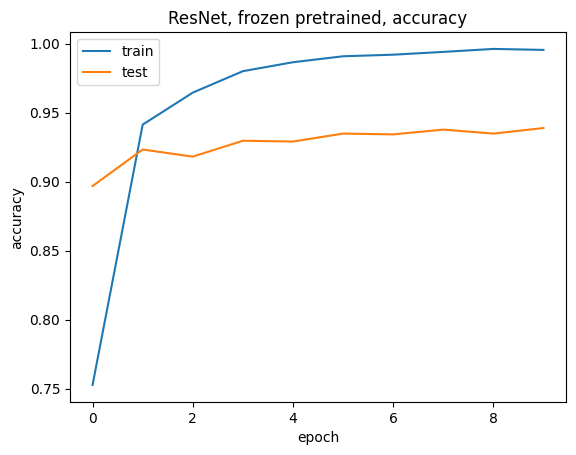

In [ ]:
# графік навчання, точність моделі
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet, frozen pretrained, accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

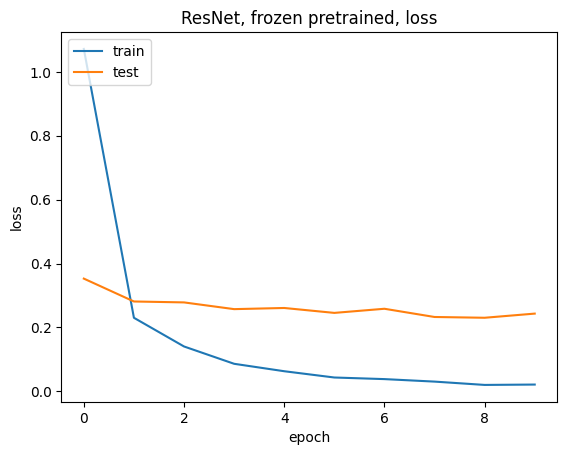

In [ ]:
# графік навчання, втрати під час навчання моделі
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet, frozen pretrained, loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Звіт про класифікацію:

In [ ]:
from sklearn.metrics import classification_report

# Передбачення міток для датасету val_ds
predictions = []
true_labels = []

for images, labels in val_ds:
    predictions.extend(new_model1.predict(images))
    true_labels.extend(labels.numpy())

# Перетворення передбачень у масив NumPy
predictions = np.array(predictions)
# Перетворення передбачень в мітки (наприклад, 0 або 1 для бінарної класифікації)
predicted_labels = np.argmax(predictions, axis=1)

# Отримання звіту про класифікацію
report = classification_report(true_labels, predicted_labels)

print(report)

1/1 [==============================] - 4s 4s/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        79
           1       1.00      0.99      0.99        94
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00       176
           4       1.00      0.93      0.97        15
           5       0.99      0.99      0.99       163
           6       0.50      0.57      0.53         7
           7       1.00      0.80      0.89         5
           8       1.00      0.91      0.95        11
           9       1.00      0.86      0.92        14
          10       1.00      0.94      0.97        16
          11       1.00      1.00      1.00         2
          12       0.97      0.93      0.95        30
          13       1.00      1.00      1.00        17
          14       0.57      1.00      0.73         4
          15       1.00      0.91      0.95        23
          16       0.95      1.

Матриця невідповідностей (confusion matrix):

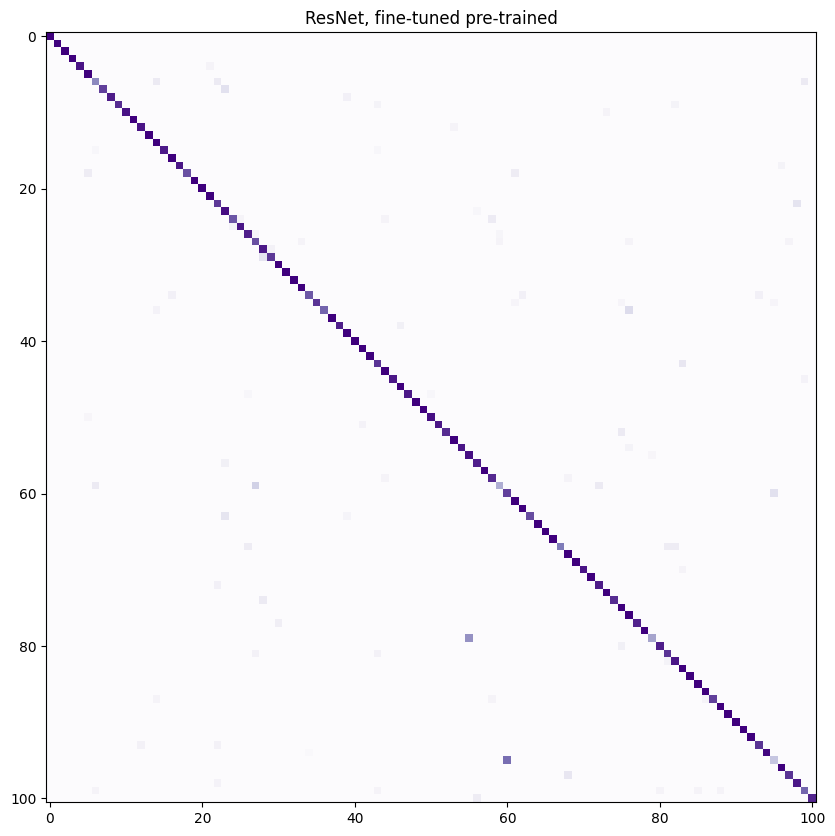

In [ ]:
from sklearn.metrics import confusion_matrix

matrix1 = confusion_matrix(true_labels, predicted_labels, normalize='true')
fig, ax = plt.subplots(figsize=(30, 10))
ax.imshow(matrix1, cmap='Purples')
ax.set_title('ResNet, fine-tuned pre-trained')
plt.show()

ROC curve plot:

ROC Curves. Frozen pre-trained ResNet
55/55 [==============================] - 10s 176ms/step


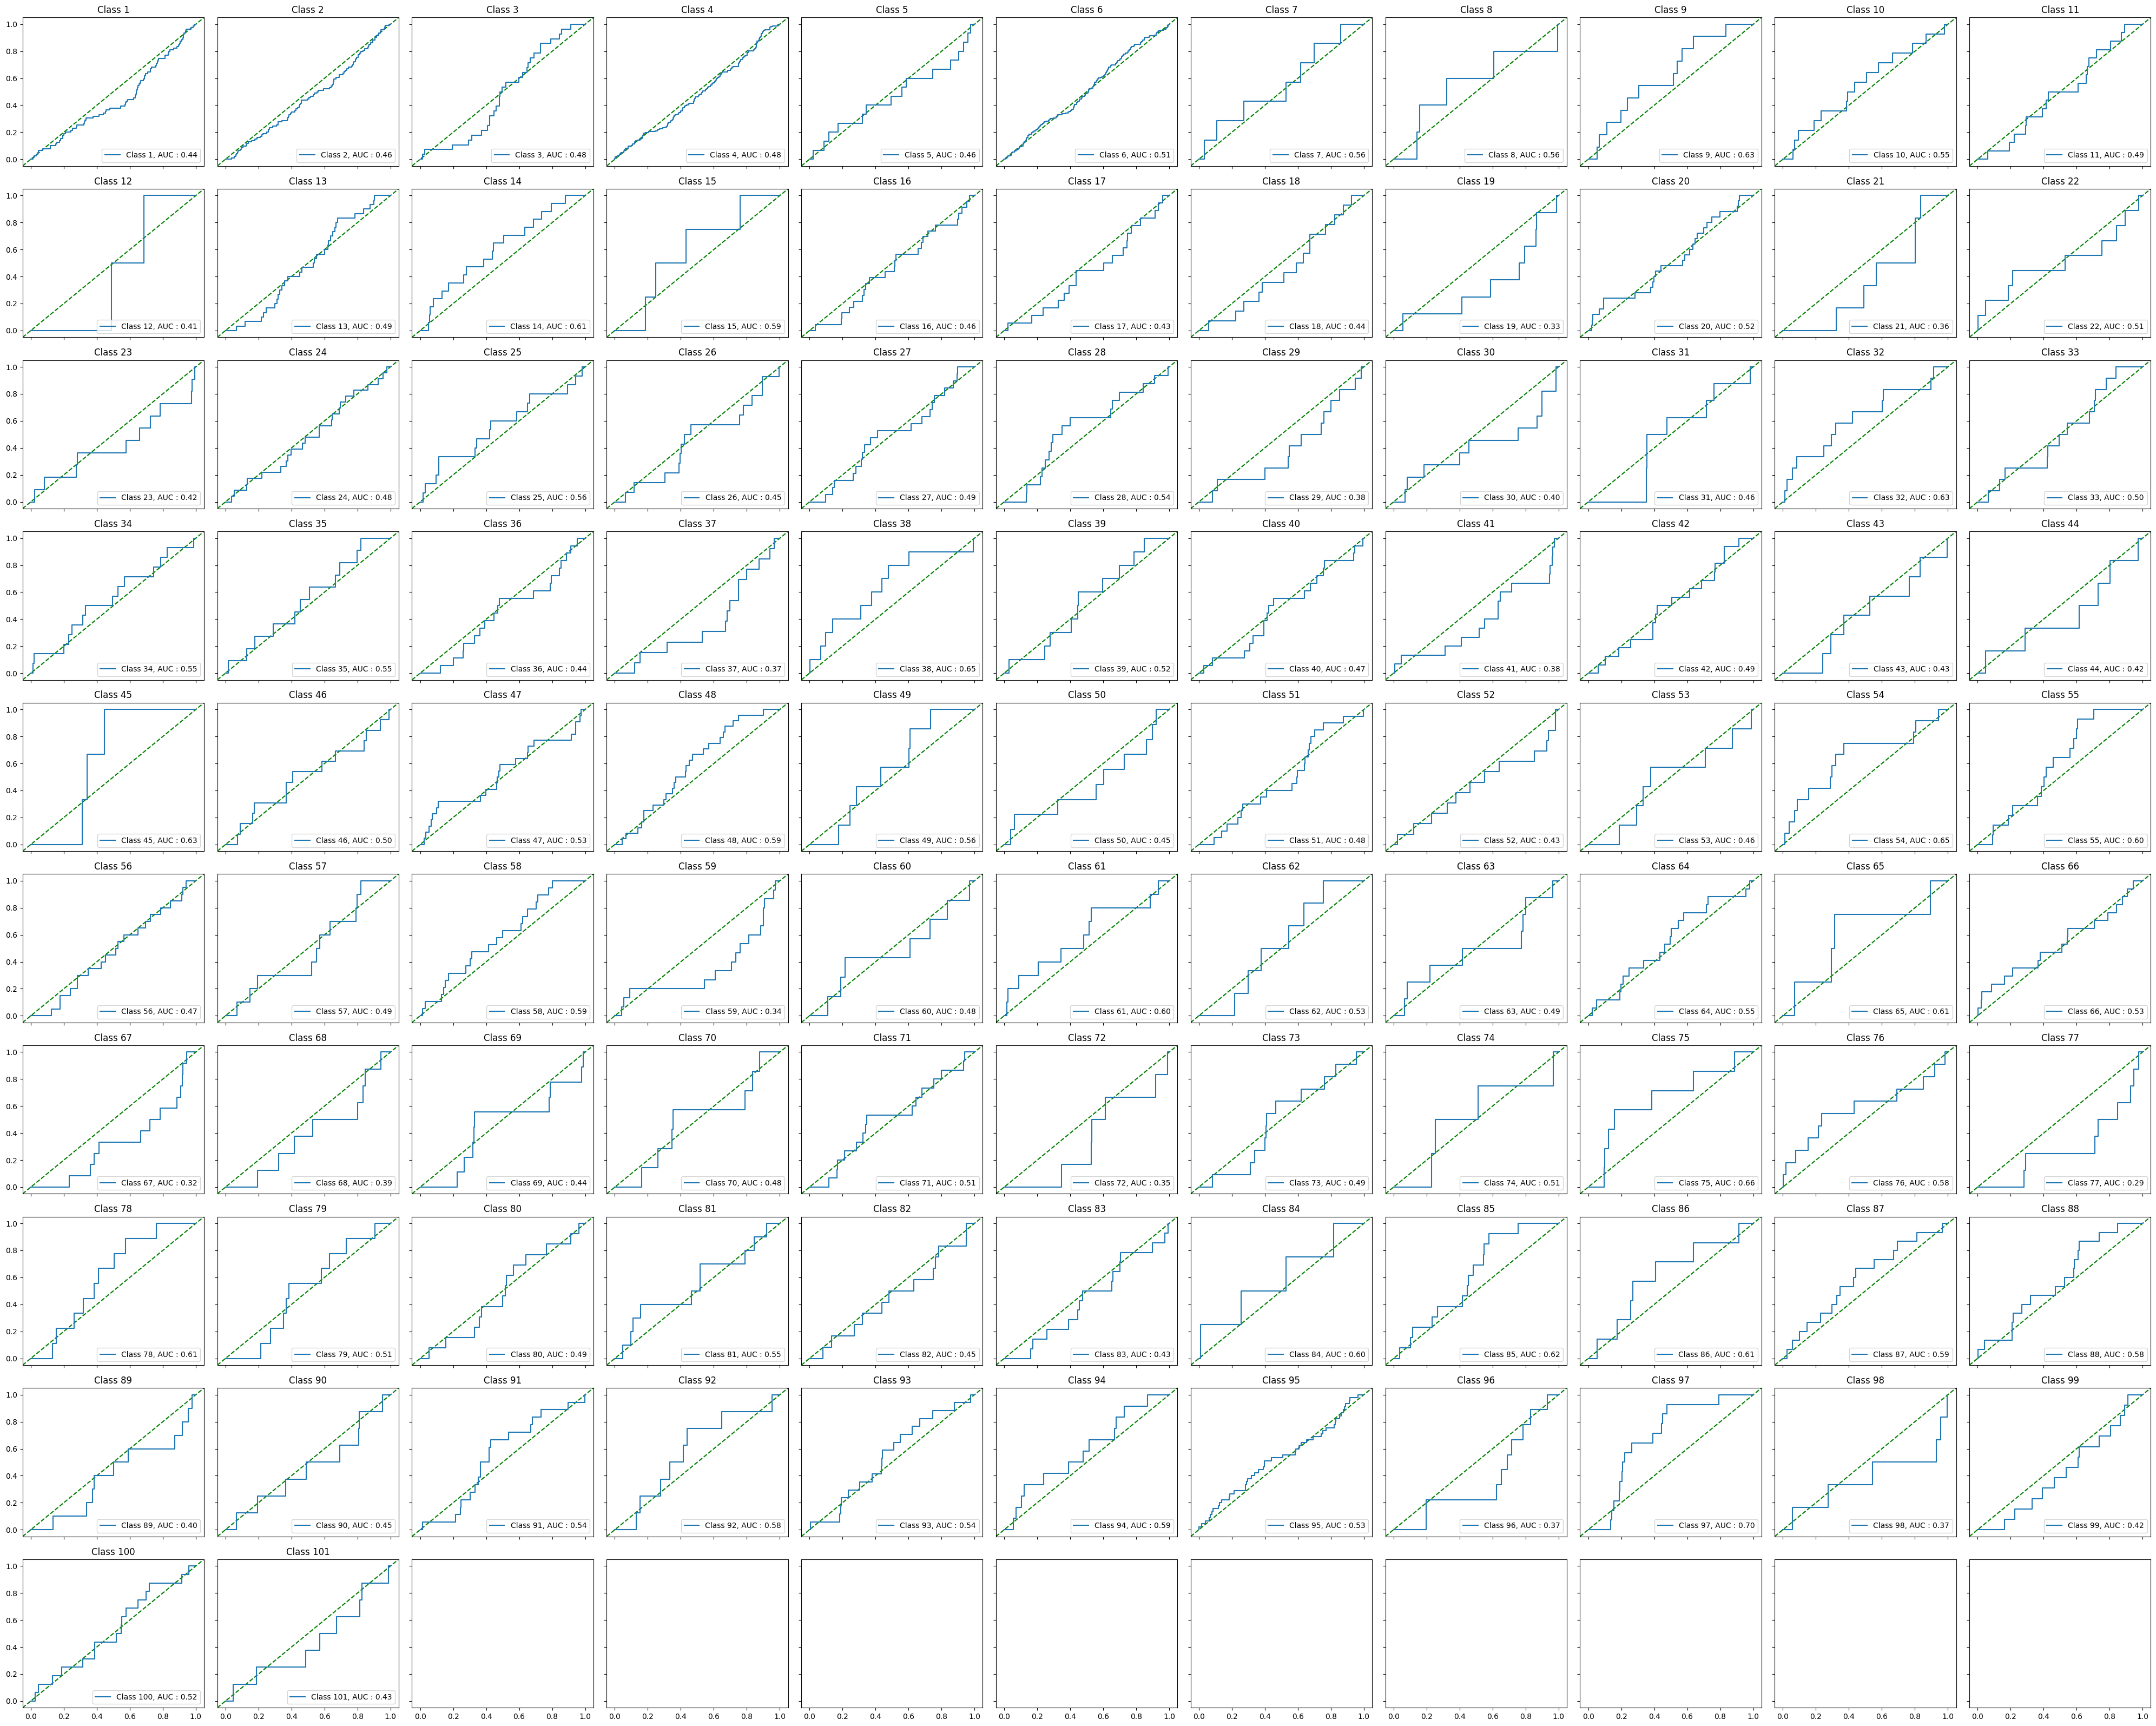

In [ ]:
import matplotlib.lines as mlines
from sklearn.metrics import roc_curve, auc

print("ROC Curves. Frozen pre-trained ResNet")

# масив істинних підписів, взятих з val_ds
true_labels = []
for images, labels in val_ds:
  true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# створюємо one-hot вектори міток
true_labels_one_hot = tf.one_hot(true_labels, depth=classes_count)
model_probs = new_model1.predict(val_ds)  # передбачення моделі

fig, axs = plt.subplots(10, 11, figsize=(40, 32), sharex=True, sharey=True)
for i in range(classes_count):
  ax = axs[i // 11, i % 11]
  line = mlines.Line2D([0, 1], [0, 1], ls="--", color='green')  # діагональ ROC-кривої
  transform = ax.transAxes  # визначення трансформації для координат, щоб правильно побудувати лінію
  line.set_transform(transform)  # встановлення трансформації для лінії

  # побудова ROC curve
  fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], model_probs[:, i])
  auc_score = auc(fpr, tpr)  # площа під ROC-кривою для значень FPR та TPR (false/true positive rate)

  ax.add_line(line)
  ax.plot(fpr, tpr, label=f'Class {i+1}, AUC : {auc_score:.2f}')
  ax.legend(loc='lower right')
  ax.set_title(f'Class {i+1}')

plt.tight_layout()
plt.show()

AUC-PRC plot:

PRC Curves. Frozen pre-trained ResNet
55/55 [==============================] - 9s 160ms/step


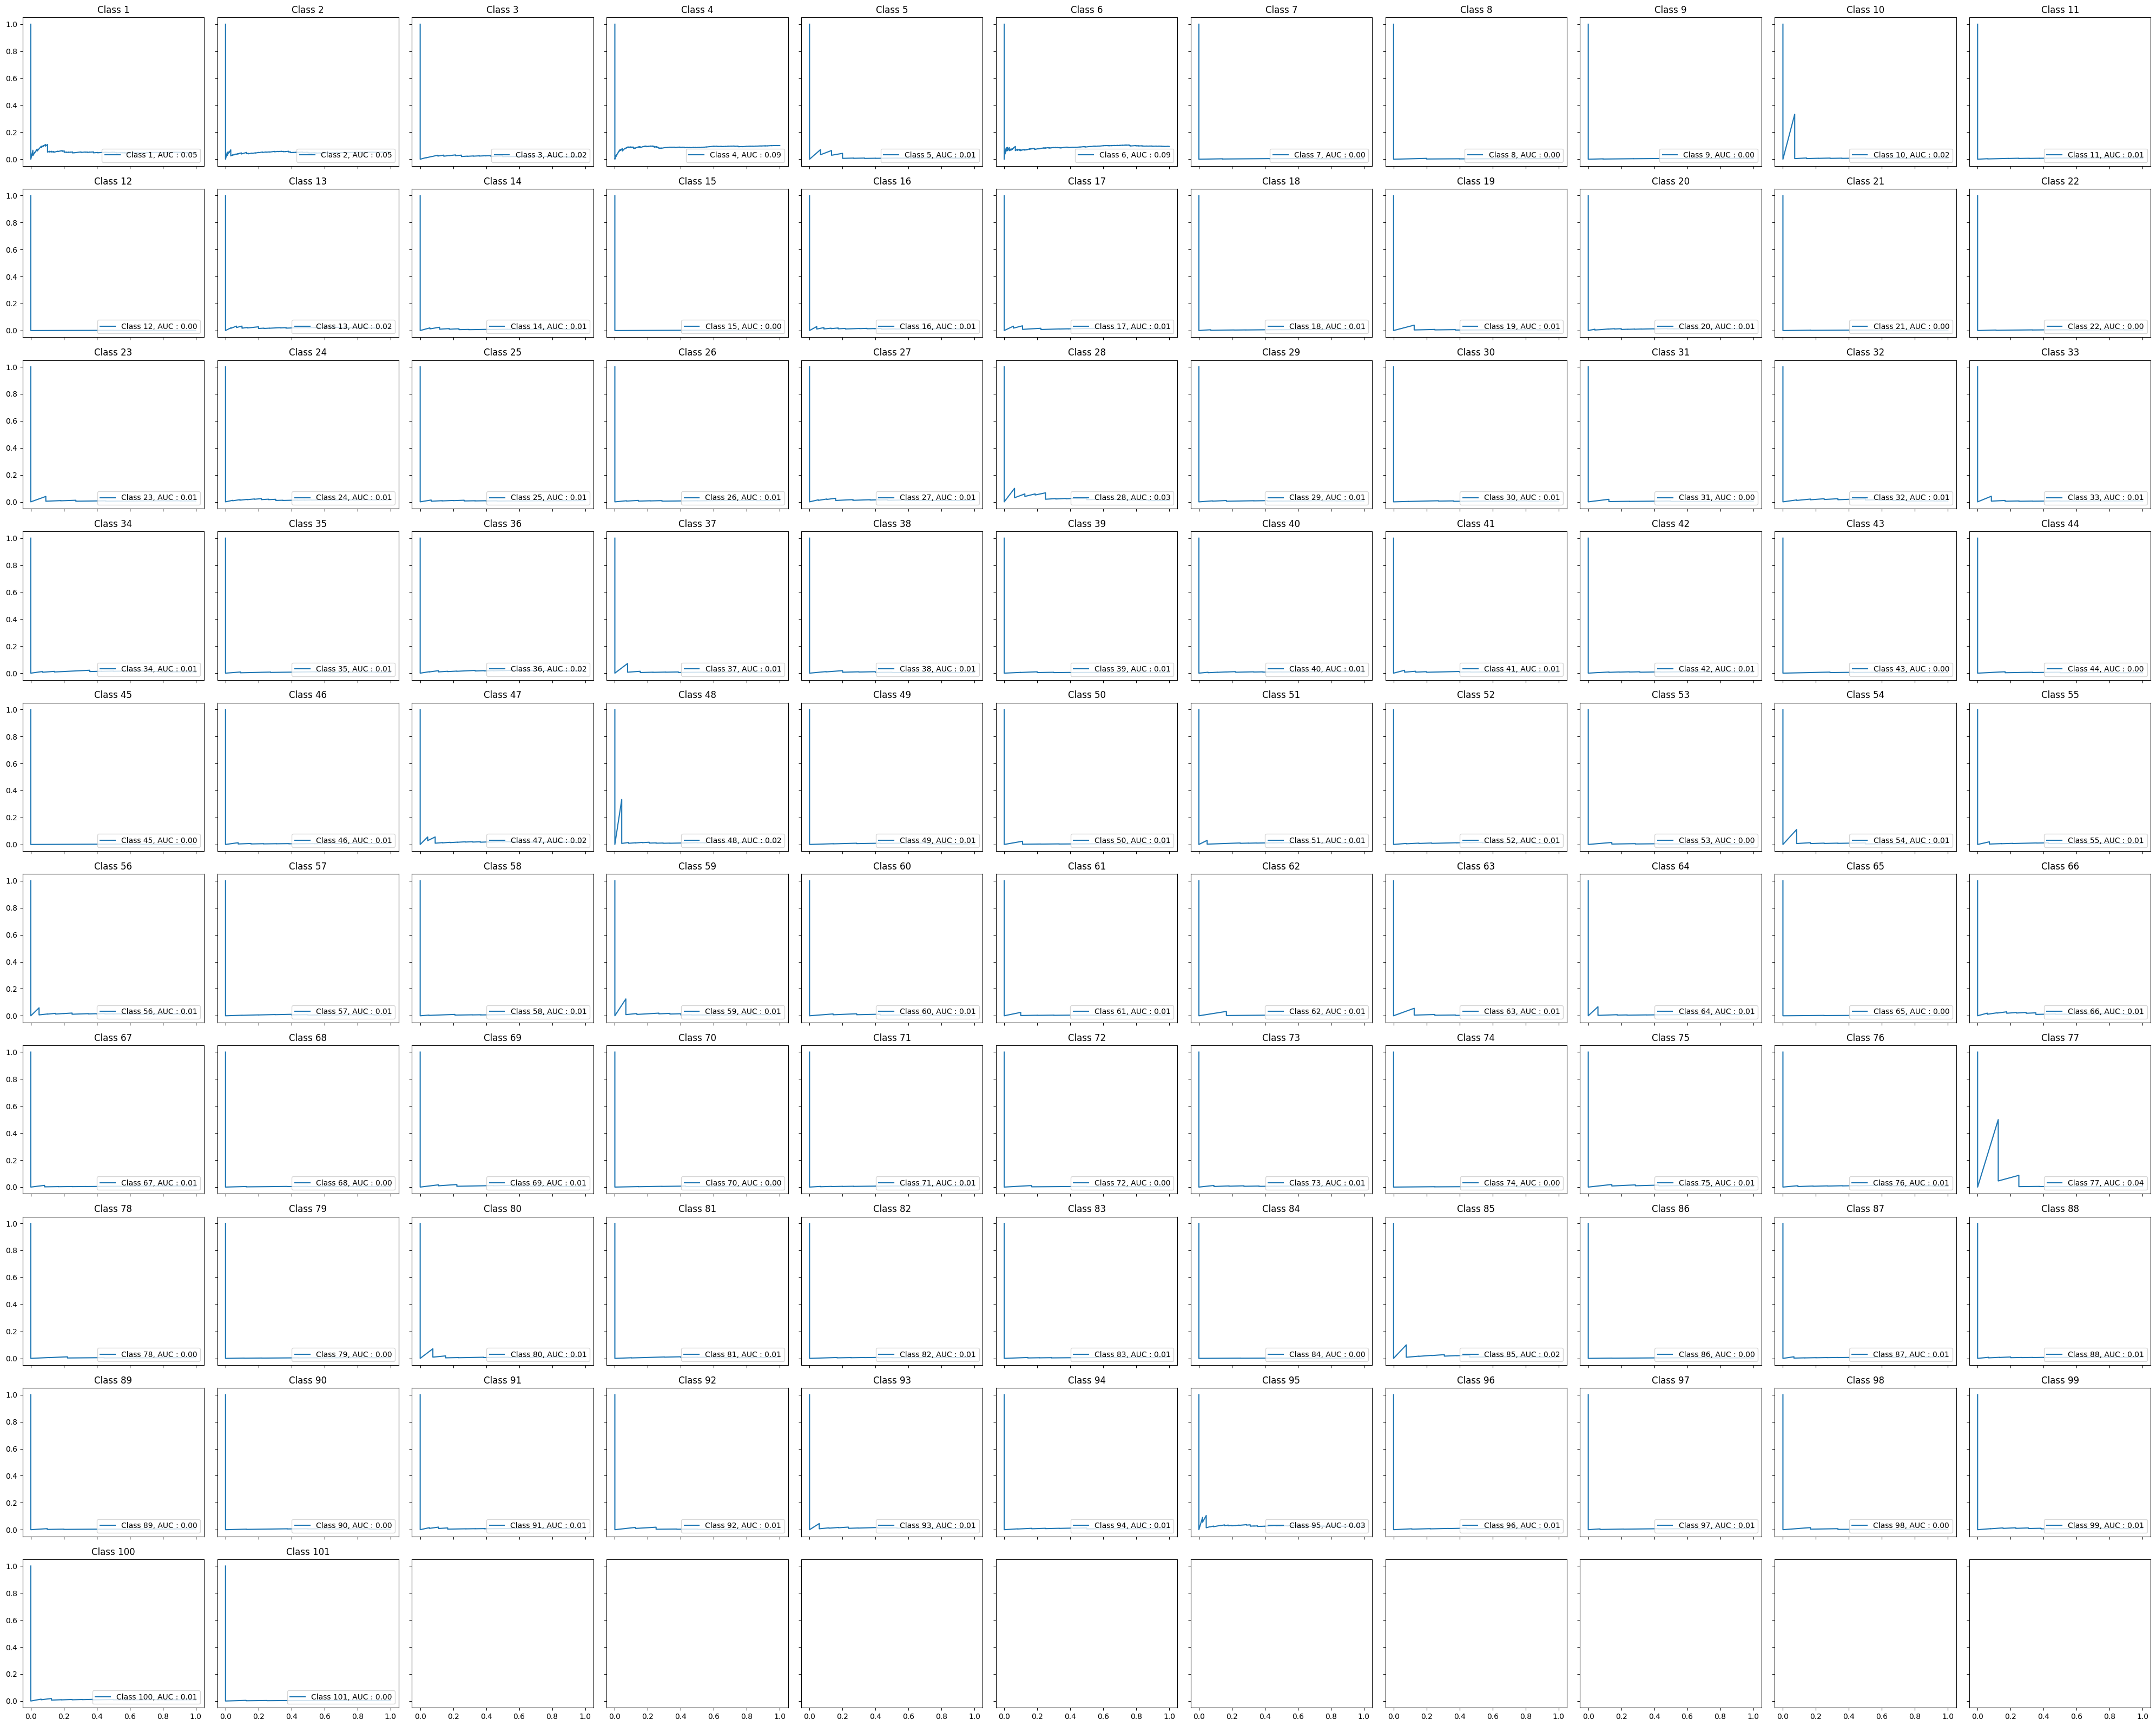

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# будуємо PRC curve
print("PRC Curves. Frozen pre-trained ResNet")

# масив істинних підписів, взятих з val_ds
true_labels = []
for images, labels in val_ds:
  true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# створюємо one-hot вектори міток
true_labels_one_hot = tf.one_hot(true_labels, depth=classes_count)
model_probs = new_model1.predict(val_ds)  # передбачення моделі

fig, axs = plt.subplots(10, 11, figsize=(40, 32), sharex=True, sharey=True)
for i in range(classes_count):
  ax = axs[i // 11, i % 11]

  # побудова PRC Curve
  precision, recall, _ = precision_recall_curve(true_labels_one_hot[:, i], model_probs[:, i])
  auc_score = auc(recall, precision)

  ax.plot(recall, precision, label=f'Class {i+1}, AUC : {auc_score:.2f}')
  ax.legend(loc='lower right')
  ax.set_title(f'Class {i+1}')
plt.tight_layout()
plt.show()

Оцінка top-1 error rate (у відсотках, %):

In [ ]:
from sklearn.metrics import accuracy_score
rate1 = (1 - accuracy_score(true_labels, predicted_labels)) * 100

print(f"Top-1 error rate, frozen pre-trained ResNet101V2: {rate1} %")

Top-1 error rate, frozen pre-trained ResNet101V2: 6.109510086455328 %


### Попередньо навчена ResNet (Fine-tuned pre-trained ResNet)

#### 3.1 Навчання

Застосуємо перетворення зображень до необхідного формату + випадкових перетворень (зміна контрасту, яскравости, випадкове горизонтальне-вертикальне перевертання).

In [ ]:
train_ds = ds_train.map(train_transform)
val_ds = ds_val.map(val_transform)

Ініціалізація моделі:

In [ ]:
def initialize_pretrained_resnet():
  model = ResNet101V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# без freeze
  return Sequential([
      model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(classes_count)
  ])

Компіляція моделі та збереження:

In [ ]:
model_pretrained_resnet = initialize_pretrained_resnet()

In [ ]:
model_pretrained_resnet.compile(
              optimizer='adam',  # оптимізатор Adam
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # функція втрат
              metrics=['accuracy']  # точність, скільки класів показала правильно
)

Навчання моделі:

In [ ]:
history = model_pretrained_resnet.fit(
  train_ds,
  validation_data=val_ds,
  epochs=8
)

Epoch 1/8
217/217 [==============================] - 189s 583ms/step - loss: 2.7159 - accuracy: 0.4065 - val_loss: 4.1678 - val_accuracy: 0.2905
Epoch 2/8
217/217 [==============================] - 120s 549ms/step - loss: 1.5565 - accuracy: 0.6063 - val_loss: 2.0853 - val_accuracy: 0.5268
Epoch 3/8
217/217 [==============================] - 119s 546ms/step - loss: 1.0277 - accuracy: 0.7236 - val_loss: 1.3861 - val_accuracy: 0.6634
Epoch 4/8
217/217 [==============================] - 119s 545ms/step - loss: 0.7365 - accuracy: 0.7963 - val_loss: 2.3880 - val_accuracy: 0.5908
Epoch 5/8
217/217 [==============================] - 120s 550ms/step - loss: 0.5458 - accuracy: 0.8430 - val_loss: 1.4672 - val_accuracy: 0.6790
Epoch 6/8
217/217 [==============================] - 120s 550ms/step - loss: 0.3939 - accuracy: 0.8895 - val_loss: 1.0194 - val_accuracy: 0.7643
Epoch 7/8
217/217 [==============================] - 119s 545ms/step - loss: 0.3078 - accuracy: 0.9127 - val_loss: 1.1947 - val_ac

Збереження моделі:

In [ ]:
model_pretrained_resnet.save('/content/drive/MyDrive/models2/')

Перевірка завантаження моделі з диску:

In [ ]:
new_model2 = tf.keras.models.load_model('/content/drive/MyDrive/models2/')

new_model2.summary()  # архітектура
loss, acc = new_model2.evaluate(val_ds, verbose=2)  # точність моделі на валідаційному наборі даних
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))  # вивід у %

print(new_model2.predict(val_ds).shape)  # виводить форму виходу передбачень моделі для валідаційного набору даних

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               206949    
                                                                 
Total params: 42833509 (163.40 MB)
Trainable params: 42735845 (163.02 MB)
Non-trainable params: 97664 (381.50 KB)
_________________________________________________________________
55/55 - 487s - loss: 0.8663 - accuracy: 0.7816 - 487s/epoch - 9s/step
Restored model, accuracy: 78.16%
55/55 [==============================] - 482s 9s/step
(1735, 101)


#### 3.2 Звіт результатів тренування/валідації

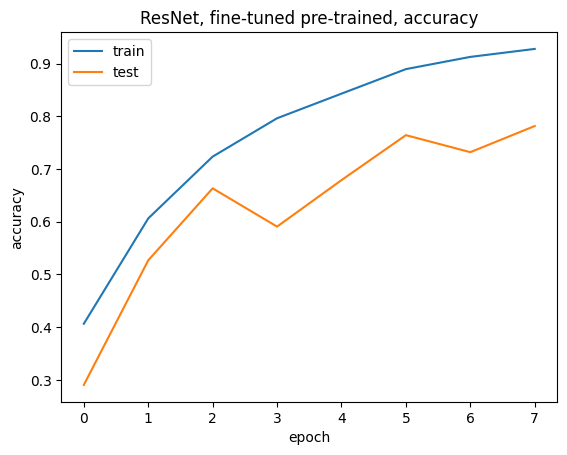

In [ ]:
# графік навчання, точність моделі
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet, fine-tuned pre-trained, accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

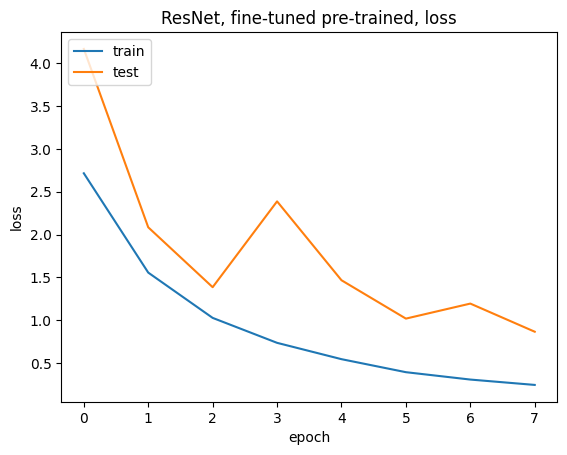

In [ ]:
# графік навчання, втрати під час навчання моделі
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet, fine-tuned pre-trained, loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Звіт про класифікацію:

In [ ]:
from sklearn.metrics import classification_report

# Передбачення міток для датасету ds_val
predictions = []
true_labels = []

for images, labels in val_ds:
    predictions.extend(new_model2.predict(images))
    true_labels.extend(labels.numpy())

# Перетворення передбачень у масив NumPy
predictions = np.array(predictions)
# Перетворення передбачень в мітки (наприклад, 0 або 1 для бінарної класифікації)
predicted_labels = np.argmax(predictions, axis=1)

# Отримання звіту про класифікацію
report = classification_report(true_labels, predicted_labels)

print(report)

1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        79
           1       0.99      0.99      0.99        94
           2       0.87      0.96      0.92        28
           3       0.96      1.00      0.98       176
           4       1.00      0.73      0.85        15
           5       0.96      0.99      0.98       163
           6       1.00      0.14      0.25         7
           7       0.33      0.40      0.36         5
           8       0.86      0.55      0.67        11
           9       0.47      0.57      0.52        14
          10       0.00      0.00      0.00        16
          11       1.00      0.50      0.67         2
          12       0.93      0.83      0.88        30
          13       0.88      0.82      0.85        17
          14       0.50      0.50      0.50         4
          15       0.83      0.87      0.85        23
          16       0.77      0.

Матриця невідповідностей (confusion matrix):

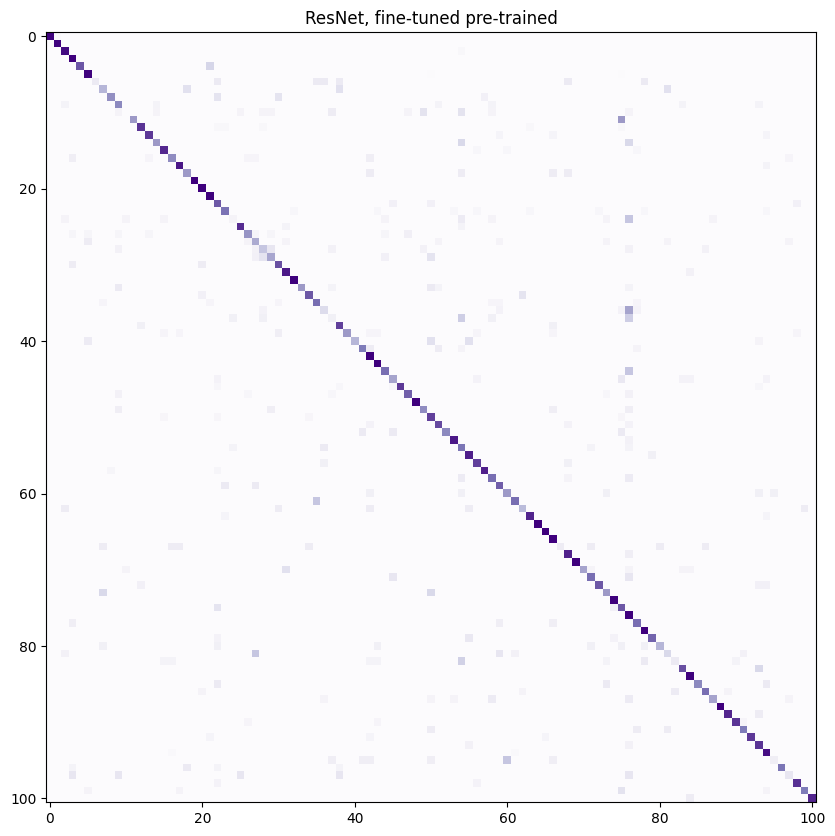

In [ ]:
from sklearn.metrics import confusion_matrix

matrix2 = confusion_matrix(true_labels, predicted_labels, normalize='true')
fig, ax = plt.subplots(figsize=(30, 10))
ax.imshow(matrix2, cmap='Purples')
ax.set_title('ResNet, fine-tuned pre-trained')
plt.show()

ROC curve plot:

ROC Curves. Fine-tuned pre-trained ResNet
55/55 [==============================] - 9s 147ms/step


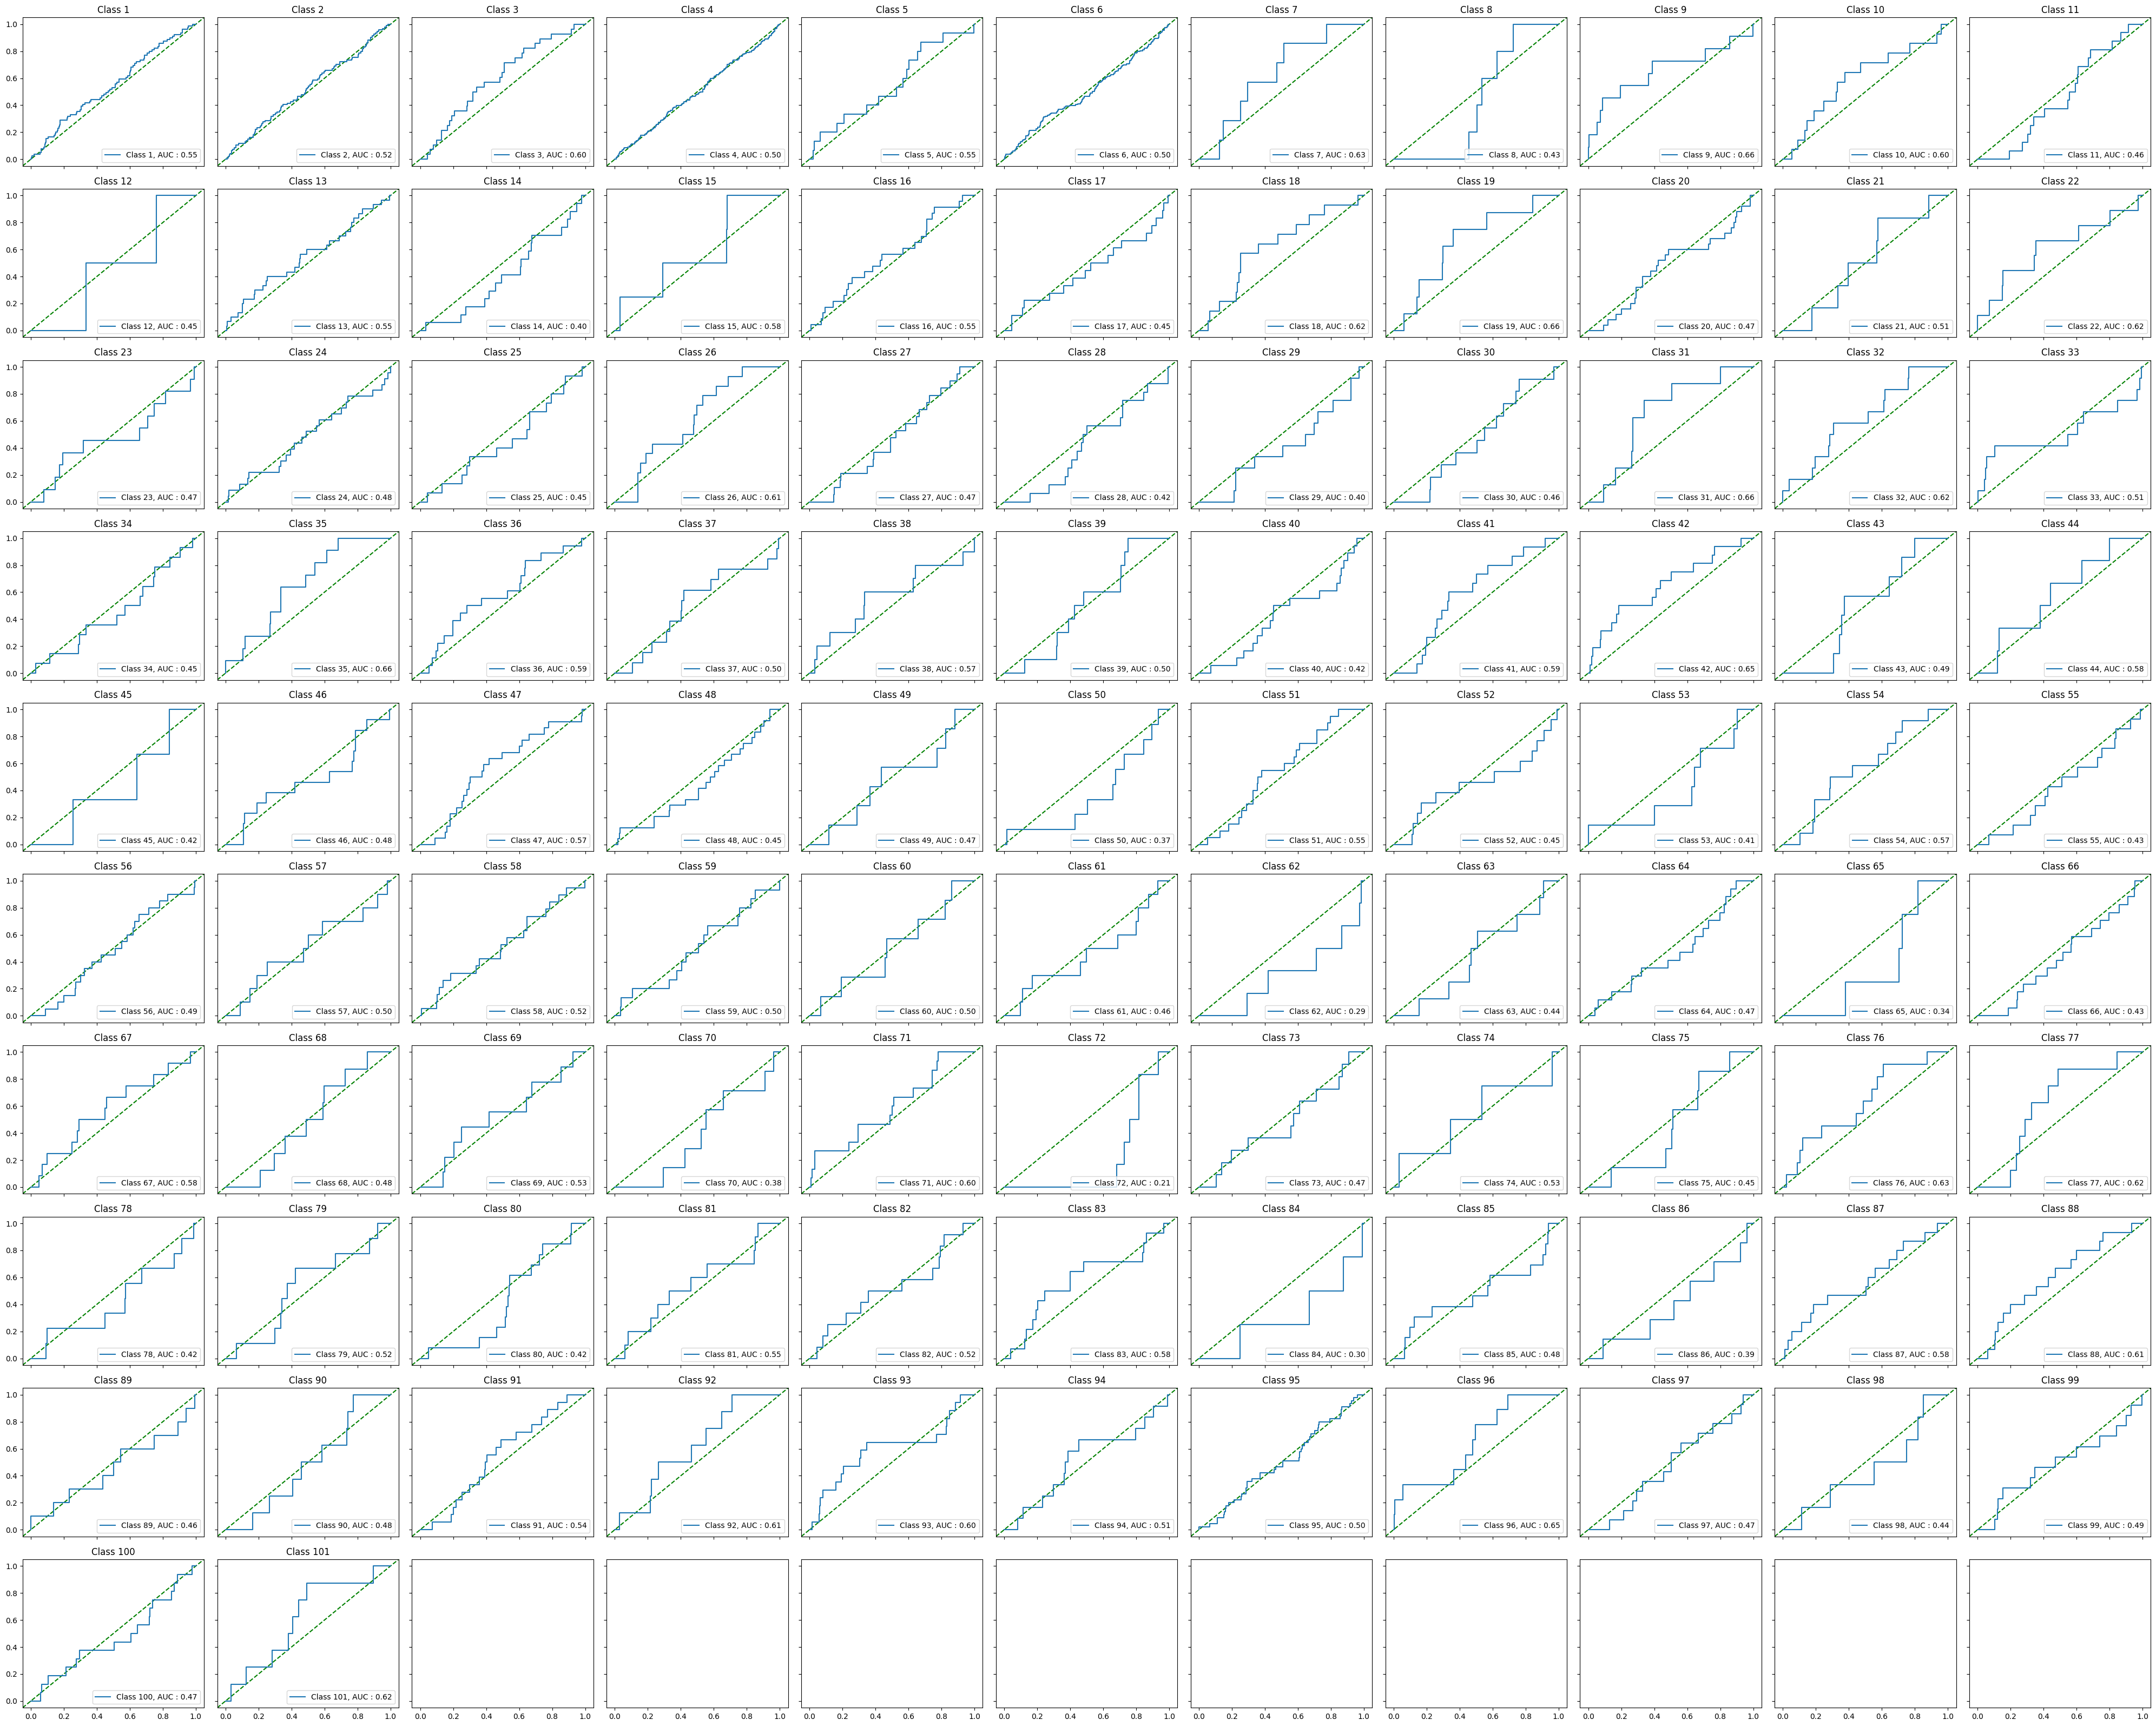

In [ ]:
import matplotlib.lines as mlines
from sklearn.metrics import roc_curve, auc

print("ROC Curves. Fine-tuned pre-trained ResNet")

# масив істинних підписів, взятих з val_ds
true_labels = []
for images, labels in val_ds:
  true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# створюємо one-hot вектори міток
true_labels_one_hot = tf.one_hot(true_labels, depth=classes_count)
model_probs = model_pretrained_resnet.predict(val_ds)  # передбачення моделі

fig, axs = plt.subplots(10, 11, figsize=(40, 32), sharex=True, sharey=True)
for i in range(classes_count):
  ax = axs[i // 11, i % 11]
  line = mlines.Line2D([0, 1], [0, 1], ls="--", color='green')  # діагональ ROC-кривої
  transform = ax.transAxes  # визначення трансформації для координат, щоб правильно побудувати лінію
  line.set_transform(transform)  # встановлення трансформації для лінії

  # побудова ROC curve
  fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], model_probs[:, i])
  auc_score = auc(fpr, tpr)  # площа під ROC-кривою для значень FPR та TPR (false/true positive rate)

  ax.add_line(line)
  ax.plot(fpr, tpr, label=f'Class {i+1}, AUC : {auc_score:.2f}')
  ax.legend(loc='lower right')
  ax.set_title(f'Class {i+1}')

plt.tight_layout()
plt.show()

AUC-PRC plot:

PRC Curves. Fine-tuned pre-trained ResNet
55/55 [==============================] - 9s 160ms/step


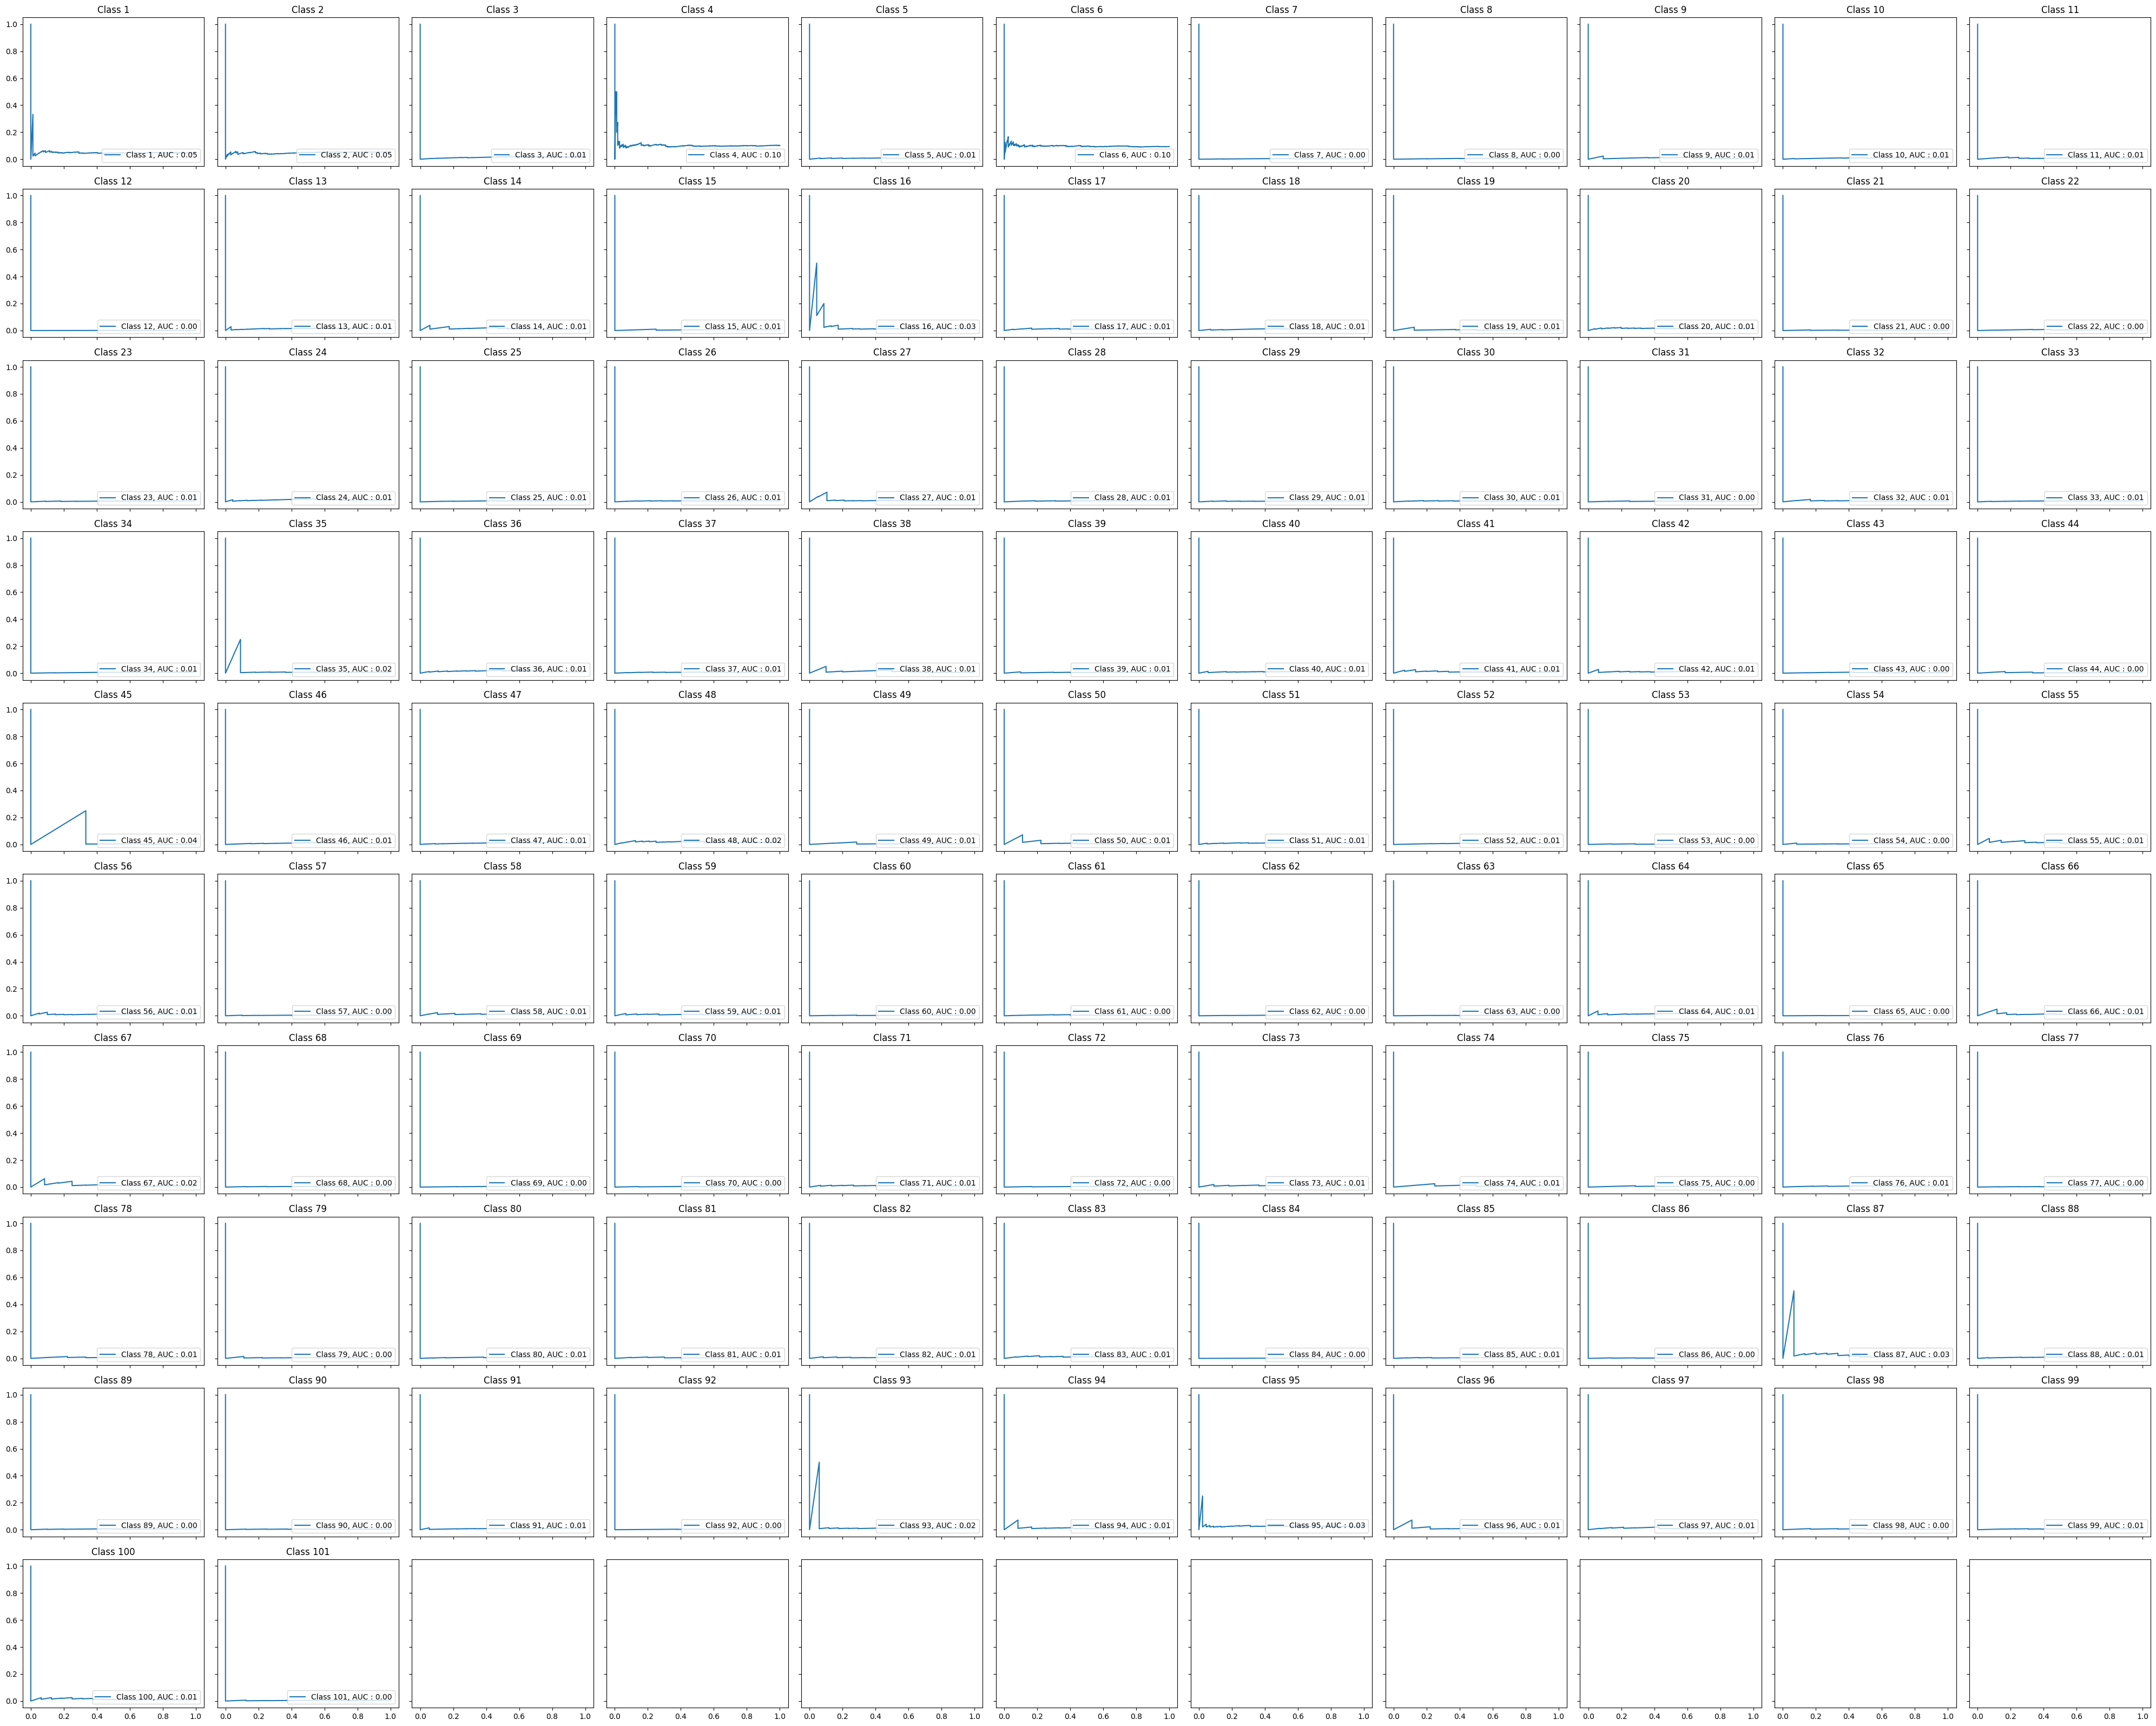

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

# будуємо PRC curve
print("PRC Curves. Fine-tuned pre-trained ResNet")

# масив істинних підписів, взятих з val_ds
true_labels = []
for images, labels in val_ds:
  true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# створюємо one-hot вектори міток
true_labels_one_hot = tf.one_hot(true_labels, depth=classes_count)
model_probs = model_pretrained_resnet.predict(val_ds)  # передбачення моделі

fig, axs = plt.subplots(10, 11, figsize=(40, 32), sharex=True, sharey=True)
for i in range(classes_count):
  ax = axs[i // 11, i % 11]

  # побудова PRC Curve
  precision, recall, _ = precision_recall_curve(true_labels_one_hot[:, i], model_probs[:, i])
  auc_score = auc(recall, precision)

  ax.plot(recall, precision, label=f'Class {i+1}, AUC : {auc_score:.2f}')
  ax.legend(loc='lower right')
  ax.set_title(f'Class {i+1}')
plt.tight_layout()
plt.show()

Оцінка top-1 error rate (у відсотках, %):

In [ ]:
from sklearn.metrics import accuracy_score
rate2 = (1 - accuracy_score(true_labels, predicted_labels)) * 100

print(f"Top-1 error rate, fine-tuned pre-trained ResNet101V2: {rate2} %")

Top-1 error rate, fine-tuned pre-trained ResNet101V2: 21.844380403458207 %


### Візуалізація фільтрів та відповідних feature maps для перших 2 Conv2d шарів простої CNN

Перші 2 Conv2d шари мають індекси 2, 4.

In [ ]:
import matplotlib.pyplot as plt

# Загрузка збереженої моделі
new_model = tf.keras.models.load_model('/content/drive/MyDrive/models/')

# Отримання ваг з першого та другого Conv2D шарів
conv1_weights = new_model.layers[2].get_weights()[0]
conv2_weights = new_model.layers[4].get_weights()[0]

First Conv2d layer


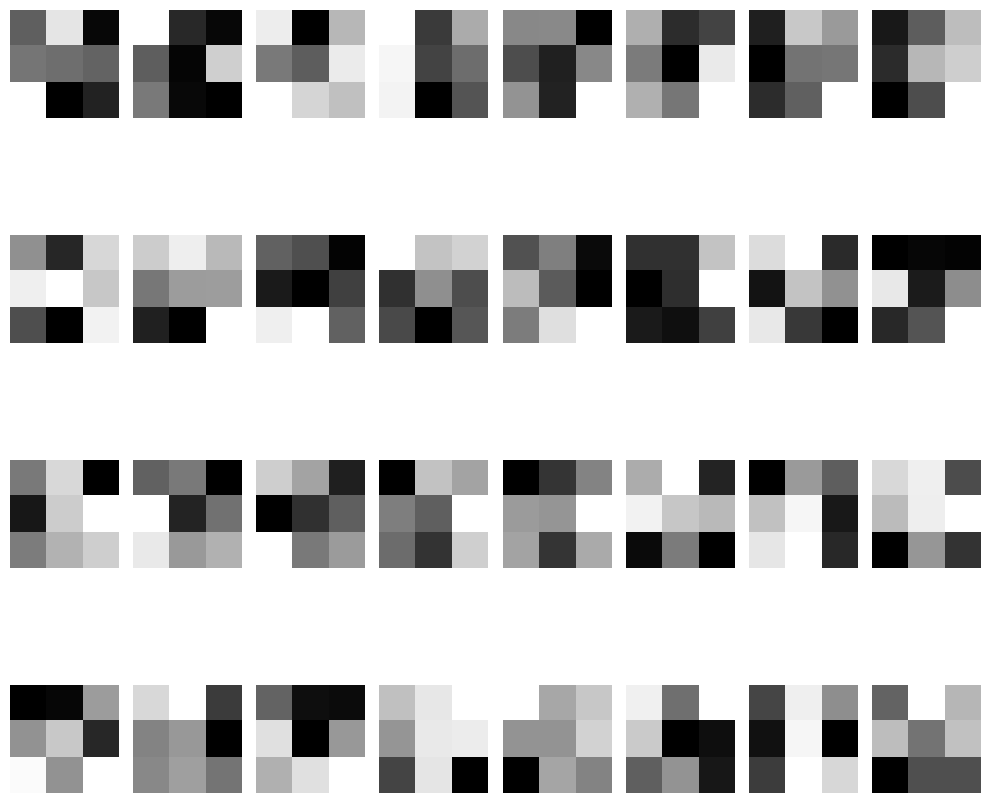

In [ ]:
# Відображення фільтрів першого шару
print("First Conv2d layer")
plt.figure(figsize=(10, 10))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    ax.imshow(conv1_weights[:, :, 0, i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Second Conv2d layer


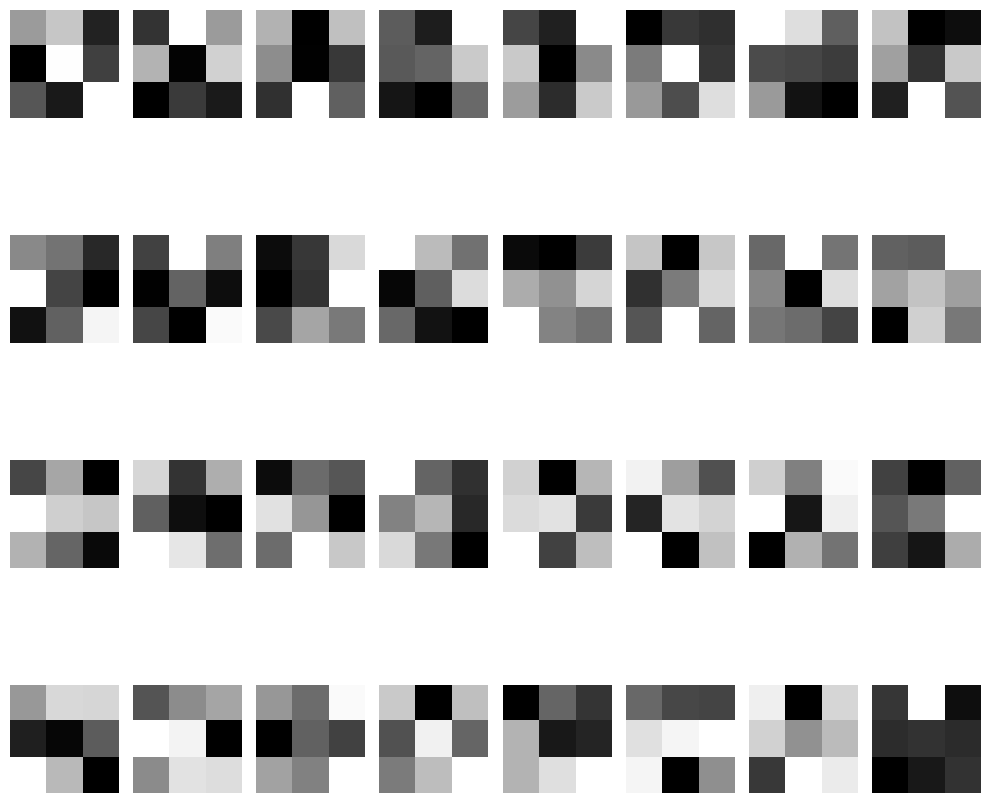

In [ ]:
# Відображення фільтрів другого шару
print("Second Conv2d layer")
plt.figure(figsize=(10, 10))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    ax.imshow(conv2_weights[:, :, 0, i], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

Функція, яка покаже фільтри на випадковому зображенні із валідаційної вибірки:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_filters_on_image(model, dataset, layer_index, image_index):
    # витягуємо
    layer_output = model.layers[layer_index].output  # вихідний тензор для певного шару моделі

    # створюємо модель, яка приймає на вхід зображення та повертає вихідний тензор обраного шару
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_output)

    # отримуємо випадкове зображення та його мітку з датасету
    for images, labels in dataset.take(1):
        image = images[image_index]
        label = labels[image_index]

    # розширюємо розмірність зображення для передачі в модель
    image = np.expand_dims(image, axis=0)

    # передаємо зображення через модель, щоб отримати активацію шару
    activations = activation_model.predict(image)

    # візуалізація фільтрів
    plt.figure(figsize=(10, 10))
    for i in range(activations.shape[-1]):
        plt.subplot(8, 8, i+1)
        plt.imshow(activations[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.show()

Викличемо функцію для першого і другого Conv2D шарів простої CNN (індекси 2 та 4).

1/1 [==============================] - 0s 80ms/step


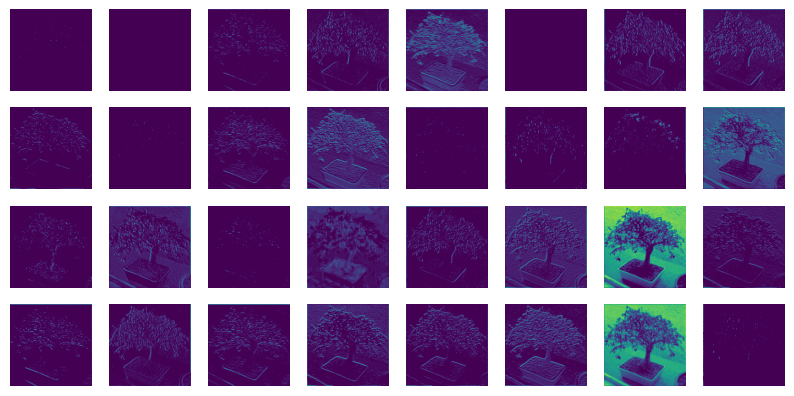

1/1 [==============================] - 0s 76ms/step


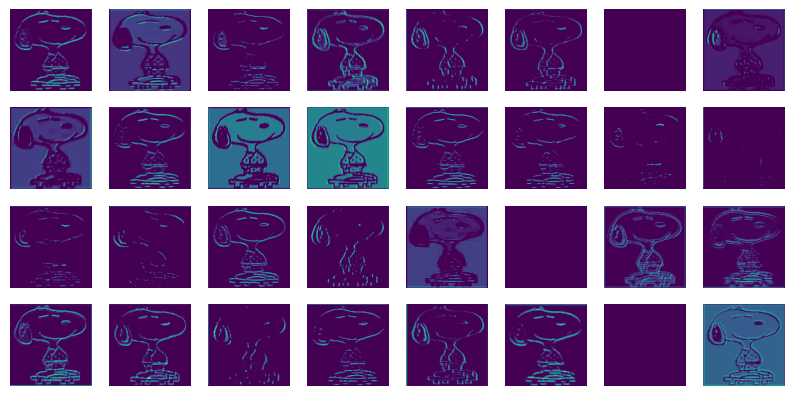

In [ ]:
plot_filters_on_image(new_model, ds_val, 2, 0)  # перший шар
plot_filters_on_image(new_model, ds_val, 4, 0)  # другий шар

### Висновки

1. What kind of features did filters extract?
- З того, що видно на зображеннях вище, схоже, що фільтри виділяють особливості об'єктів: краї, контури, їх текстури. Деякі фільтри зосереджувалися на заливці. Частина враховувала радше горизонтальні лінії, інша -- вертикальні.
2. Do you have "blind" filters that didn't learn anything? Why? How could you fix that?
- На зображеннях вище бачимо, що як мінімум 7 фільтрів у першому Conv2d шарі не розпізнали особливостей об'єктів (зображення з фільтрами суцільно сині), і 3 фільтри -- у другому Conv2d шарі. Таке може ставатися, якщо фільтр отримує надто мало інформації або якщо навчання моделі перервано раніше. Щоб виправити це, можна спробувати збільшити кількість навчальних епох або використати іншу архітектуру моделі.
3. Does your model consider the background of the inputs?
- Моя модель не повністю враховує фон вхідних даних. Вона фокусується радше на виділенні основних особливостей об'єктів на передньому плані, а не на деталях фону.
4. Does your model consider the color of the inputs?
- Моя модель враховує кольори, бо на вході я передаю 3 канали: RGB.